In [1]:
import snap
import random as rd
import numpy as np
from dataclasses import dataclass, field
import queue
from numpy.linalg import inv
import numpy.linalg as lg
import matplotlib.pyplot as plt
import copy
import time
from tqdm.notebook import trange, tqdm

#G5 = snap.LoadEdgeList(snap.TUNGraph, "com-orkut.ungraph.txt", 0, 1)
#N_G = G5.GetNodes()

In [11]:
def extract_subgraph(n): # extract a subgrpah of n points from G
    D = {}
    while len(D)<n:
        D[rd.randint(0,N_G)]=1
    L = [key for key in D]
    #print(D)
    #print(L)
    return L

def aux(G,n):
    D={}
    Q = queue.Queue()
    x = rd.randint(0,N_G)
    D[x]=1
    Q.put(x)
    while len(D)<n:
        x = Q.get()
        for e in G.GetNI(x).GetOutEdges():
            if len(D)>n:
                break
            if not e in D:
                D[e]=1
                Q.put(e)
    L = [key for key in D]
    return L

def extract_subgraph2(G,N):
    n= 2*N
    while n>1.2*N:
        L = aux(G,N)
        n = len(L)
    return L

def node_convertor(G):
    n = len(list(G.Nodes()))
    L = [0]*n
    D = {}
    i = 0
    for N in G.Nodes():
        L[i] = N.GetId()
        D[N.GetId()] = i
        i+=1
    return L,D

def matrix_convertor(G,D):
    n = len(list(G.Nodes()))
    A = np.zeros((n,n))
    for e in G.Edges():
        i = D[e.GetSrcNId()]
        j = D[e.GetDstNId()]
        A[i,j] = 1
    return A

def matrix_convertor_un(G,D):
    n = len(list(G.Nodes()))
    A = np.zeros((n,n))
    for e in G.Edges():
        i = D[e.GetSrcNId()]
        j = D[e.GetDstNId()]
        A[i,j] = 1
        A[j,i] = 1
    return A

def katz_matrix(A,alpha,Eig=False):  
    n,_ = A.shape
    if Eig:
        v,_ = lg.eig(A)
        V = []
        for i in range(n):
            V.append(v[i])
        V.sort()
        print(1/abs(V[-1]))
    
    I = np.eye(n)
    J = np.ones(n)
    return ((inv((I-alpha*A))-I)@J)

def loss_bias_error(real_katz,noisy_katz,n):
    E = 0
    B = 0
    R = 0
    for i in range(n):
        E+=(real_katz[i]-noisy_katz[i])**2/n
        B+=(real_katz[i]-noisy_katz[i])/n
        R+=abs(real_katz[i]-noisy_katz[i])/(max(n*real_katz[i],1e4))
    return E,B,R

def make_subgraph(G,N):
    L = extract_subgraph(N)
    return G.GetSubGraph(L)
    
def make_subgraph2(G,N):
    L = extract_subgraph2(G,N)
    return G.GetSubGraph(L)

def plot_several_round(G,Eps,alpha,count = 40, extract=False,N=1000):
    if extract:
        n=2*N
        while n>1.2*N:
            L = extract_subgraph2(G,N)
            G1 = G.GetSubGraph(L)
            n = len(list(G1.Nodes()))
    else:
        G1=G
        n = len(list(G1.Nodes()))
    n = len(list(G1.Nodes()))
    print(n)

    E1 = [0]*len(Eps)           
    R1 = [0]*len(Eps)
    L,D = node_convertor(G1)
    #A = matrix_convertor(G1,D)
    #r_k = katz_matrix(A,alpha)
    r_k = katz_by_graph_exploration(G1,D,L,alpha,40,n)
    for i in range(len(Eps)):
        print(i)
        n_k1 = katz_local_estimator(G1,D,L,alpha,count,Eps[i],n)
        e1,b1,r1 = loss_bias_error(r_k,n_k1,n)
        E1[i] = e1 
        R1[i] = r1 

    print('avg = ',np.mean(r_k))


    _, ax = plt.subplots()
    ax.set_yscale('log')
    plt.plot(Eps,E1,label = 'loss')
    plt.legend(loc = 'upper right')
    plt.show()

    plt.clf()
    _, ax = plt.subplots()
    ax.set_yscale('log')
    plt.plot(Eps,R1,label = 'err')
    plt.legend(loc = 'upper right')
    plt.show()
    plt.clf()

def plot_several_round2(G,Eps,alpha,count = 40, extract=False,N=1000):
    if extract:
        n=2*N
        while n>1.2*N:
            L = extract_subgraph2(G,N)
            G1 = G.GetSubGraph(L)
            n = len(list(G1.Nodes()))
    else:
        G1=G
        n = len(list(G1.Nodes()))
    n = len(list(G1.Nodes()))
    print(n)

    E1 = [0]*len(Eps)           
    R1 = [0]*len(Eps)
    L,D = node_convertor(G1)
    #A = matrix_convertor(G1,D)
    #r_k = katz_matrix(A,alpha)
    r_k = katz_by_graph_exploration(G1,D,L,alpha,40,n)
    for i in range(len(Eps)):
        print(i)
        n_k1 = katz_local_estimator2(G1,D,L,alpha,count,Eps[i],n)
        e1,b1,r1 = loss_bias_error(r_k,n_k1,n)
        E1[i] = e1 
        R1[i] = r1 

    print('avg = ',np.mean(r_k))


    _, ax = plt.subplots()
    ax.set_yscale('log')
    plt.plot(Eps,E1,label = 'loss')
    plt.legend(loc = 'upper right')
    plt.show()

    plt.clf()
    _, ax = plt.subplots()
    ax.set_yscale('log')
    plt.plot(Eps,R1,label = 'err')
    plt.legend(loc = 'upper right')
    plt.show()
    plt.clf()
    
def biggest_degree(G,L,n):
    B = np.zeros(n)
    for i in range(n):
        B[i] = G.GetNI(L[i]).GetOutDeg()+np.random.laplace(scale=2)
    return B

def katz_by_graph_exploration(G,D,L,alpha,count,n):
    B = np.zeros(n)    # store katz centrality
    C = np.ones(n)     # store number of (k-1)-path 
    X = np.zeros(n)    # store number of k-path

    for k in range(count):
        #print(max(C))
        for i in range(n):
            X[i]=0     
        for i in range(n):
            for e in G.GetNI(L[i]).GetOutEdges():
                B[i]+=alpha*C[D[e]]
                X[i]+=alpha*C[D[e]]
        for i in range(n):
            C[i]=X[i]
    return B

def small_sigma(count,alpha,X):
    S = 0
    for i in range(1,count+1):
        S+=2*alpha**2*(alpha*X)**(i-1)
        for j in range(2,count+1-i):
            S+=2*alpha*(alpha*X)**(j+i-1)
    return S
    
def big_sigma(count,alpha,X):
    S = 0
    for i in range(1,count+1):
        S+=alpha*(alpha*X)**(i-1)
        for j in range(2,count+1-i):
            S+=2*alpha*(alpha*X)**(j+i-1)
    return S
    
def proba_dens(B,scale,n):
    P = np.zeros(n)
    for i in range(n):
        P[i]=np.exp(scale*B[i])
    return 0
        
def exponential2(G,D,L,X,alpha,count,k,n,eps=1):
    B = katz_by_clipping(G,D,L,X,alpha,count,n)
    P = np.zeros(n)
    I = np.zeros(n)
    S = big_sigma(count,alpha,X)
    s = small_sigma(count,alpha,X)
    #print(S,s)
    scale = 0.5*eps/(2*S+(k-2)*s)
    #print(scale)
    for i in range(n):
        P[i]=np.exp(scale*B[i])
        I[i]=i
    P = P/sum(P)
    #print(max(P))
    output = []
    for _ in range(k):
        r = np.random.choice(I,p=P)
        output.append(int(r))
        #print(P[int(r)])
        P[int(r)]=0
        P=P/sum(P)
    return output

def build_density(R,n,k):
    A = np.zeros((n,k))
    A[n-1,k-1] = R[n-1]
    for i in range(n-2,-1,-1):
        A[i,k-1]=A[i+1,k-1]+R[i]
    for i in range(n-2,-1,-1):
        for j in range(k-1):
            A[i,j]=A[i+1,j]+R[i]*A[i+1,j+1]
    P = np.zeros((n,k))
    for i in range(n-1):
        for j in range(k-1):
            if A[i,j]>1e-10:
                P[i,j]=R[i]*A[i+1,j+1]/A[i,j]
            else:
                P[i,j]=1
        if A[i,k-1]>1e-10:
            P[i,k-1]=R[i]/A[i,k-1]
        else:
            P[i,k-1]=1
    P[n-1,k-1]=1
    return P        
    

def exponential(G,D,L,X,alpha,count,k,n,eps=1):
    B = katz_by_clipping(G,D,L,X,alpha,count,n)
    R = np.zeros(n)
    S = big_sigma(count,alpha,X)
    s = small_sigma(count,alpha,X)
    scale = 0.5*eps/(2*S+(k-2)*s)
    for i in range(n):
        R[i] = np.exp(scale*B[i])
    P = build_density(R,n,k)
    pointer = 0
    used = 0
    answer = []
    while pointer<n:
        if used>=k:
            break
        x = np.random.rand()
        if x<P[pointer,used]:
            #print(P[pointer,used])
            answer.append(pointer)
            used+=1
        pointer+=1
    return answer    
        


def expo2(G,D,L,X,alpha,count,k,n,eps=1):
    B = katz_by_clipping(G,D,L,X,alpha,count,n)
    P = np.zeros(n)
    I = np.zeros(n)
    S = big_sigma(count,alpha,X)
    scale = 0.5*eps/(k*S)
    #print(scale)
    #print(S)
    #print(scale)
    for i in range(n):
        P[i]=np.exp(scale*B[i])
        I[i]=i
    P = P/sum(P)
    output = []
    for _ in range(k):
        #print(max(P))
        r = np.random.choice(I,p=P)
        output.append(int(r))
        #print(P[int(r)])
        P[int(r)]=0
        P=P/sum(P)
    return output

def noise_n(n,alpha,X):
    S = 0
    for i in range(1,n+1):
        S+=alpha*(alpha*X)**(i-1)
        for j in range(2,n+1-i):
            S+=2*alpha*(alpha*X)**(j+i-1)
    return S

def katz_by_clipping(G,D,L,x,alpha,count,n):
    B = np.zeros(n)    # store katz centrality
    C = np.ones(n)     # store number of (k-1)-path 
    X = np.zeros(n)    # store number of k-path

    for k in range(count):
        #print(max(C),(alpha*x)**k)
        #print(k,max(C))
        for i in range(n):
            X[i]=0     
        for i in range(n):
            for e in G.GetNI(L[i]).GetOutEdges():
                X[i] += alpha*C[D[e]]
        for i in range(n):
            B[i] += X[i]
            C[i] =  min(X[i],(alpha*x)**(k+1))
    return B

def katz_by_clipping_noise(G,D,L,x,alpha,count,n,eps=1):
    B = katz_by_clipping(G,D,L,x,alpha,count,n)
    noise = noise_n(n,alpha,x)
    noise = noise*eps
    #noise2 = alpha/(1-alpha*x) + 2*alpha**3*x**2/((1-alpha*x)**2)
    #print(noise2)
    #print(noise)
    #print(max(B))
    for i in range(n):
        B[i] += np.random.laplace(scale = noise)
    return B

def search_X(G,D,L,alpha,count,n,eps):
    opt = np.inf
    opt_X = 0
    list_X = [i/(10*alpha) for i in range(10)]
    r_k = katz_by_graph_exploration(G,D,L,alpha,count,n)
    tour = 0
    for x in list_X:
        tour+=1
        n_k = katz_by_clipping_noise(G,D,L,x,alpha,count,n,eps)
        e,_,_ = loss_bias_error(r_k,n_k,n)
        print(tour,e)
        if e<opt:
            opt_X = x
            opt = e
    return opt_X
    
    
def katz_clipping_local(G,D,L,x,alpha,count,n,eps):
    B = np.zeros(n)    # store katz centrality
    C = np.ones(n)     # store number of (k-1)-path 
    X = np.zeros(n)    # store number of k-path

    for k in range(count):
        #print(max(C),(alpha*x)**k)
        T = alpha**(k+1)*x**k  #threshold
        for i in range(n):
            X[i]=0     
        for i in range(n):
            for e in G.GetNI(L[i]).GetOutEdges():
                X[i] += alpha*C[D[e]]
        for i in range(n):
            X[i] += np.random.laplace(scale = 2*count*T/eps)
            B[i] += X[i]
            C[i] = min(X[i],T*x)
    return B

def katz_clipping_opt(G,D,L,x,alpha,count,n,eps):
    B = np.zeros(n)    # store katz centrality
    C = np.ones(n)     # store number of (k-1)-path 
    X = np.zeros(n)    # store number of k-path

    for k in range(count):
        #print(max(C),(alpha*x)**k)
        #T = alpha**(k+1)*x**k  #threshold
        T = alpha*max(C)
        #print(T,alpha*(alpha*x)**k)
        #print("\n")
        for i in range(n):
            X[i]=0     
        for i in range(n):
            for e in G.GetNI(L[i]).GetOutEdges():
                X[i] += alpha*C[D[e]]
        for i in range(n):
            X[i] += np.random.laplace(scale = 2*count*T/eps)
            B[i] += X[i]
            C[i] = max(0,min(X[i],(alpha*x)**(k+1)))
    return B

def katz_without_clipping(G,D,L,alpha,count,n,eps):
    B = np.zeros(n)    # store katz centrality
    C = np.ones(n)     # store number of (k-1)-path 
    X = np.zeros(n)    # store number of k-path

    for k in range(count):
        #print(max(C),(alpha*x)**k)
        #T = alpha**(k+1)*x**k  #threshold
        T = alpha*max(C)
        #print(T,alpha*(alpha*x)**k)
        #print("\n")
        for i in range(n):
            X[i]=0     
        for i in range(n):
            for e in G.GetNI(L[i]).GetOutEdges():
                X[i] += alpha*C[D[e]]
        for i in range(n):
            X[i] += np.random.laplace(scale = 2*count*T/eps)
            B[i] += X[i]
            C[i] = X[i]
    return B

def katz_clipping_opt(G,D,L,x,alpha,count,n,eps):
    B = np.zeros(n)    # store katz centrality
    C = np.ones(n)     # store number of (k-1)-path 
    X = np.zeros(n)    # store number of k-path

    for k in range(count):
        #print(max(C),(alpha*x)**k)
        #T = alpha**(k+1)*x**k  #threshold
        T = alpha*max(C)
        #print(T,alpha*(alpha*x)**k)
        #print("\n")
        for i in range(n):
            X[i]=0     
        for i in range(n):
            for e in G.GetNI(L[i]).GetOutEdges():
                X[i] += alpha*C[D[e]]
        for i in range(n):
            X[i] += np.random.laplace(scale = 2*count*T/eps)
            B[i] += X[i]
            C[i] = max(0,min(X[i],(alpha*x)**(k+1)))
    return B

def count_path(G,D,L,count,n):
    C = np.ones(n)     # store number of (k-1)-path 
    X = np.zeros(n)    # store number of k-path
    for k in range(count):
        #print(max(C))
        for i in range(n):
            X[i]=0     
        for i in range(n):
            for e in G.GetNI(L[i]).GetOutEdges():
                X[i]+=C[D[e]]
        for i in range(n):
            C[i]=X[i]
    return C

def count_path_noise(G,D,L,count,n,eps):
    C = np.ones(n)     # store number of (k-1)-path 
    X = np.zeros(n)    # store number of k-path
    for k in range(count):
        #print(C[0:5])
        T = max(C)
        for i in range(n):
            X[i]=0     
        for i in range(n):
            for e in G.GetNI(L[i]).GetOutEdges():
                X[i]+=C[D[e]]
        for i in range(n):
            X[i] += np.random.laplace(scale = 2*count*T/eps)
            C[i] = X[i]
    return C

def count_path_clipping(G,D,L,x,count,n,eps):
    C = np.ones(n)     # store number of (k-1)-path 
    X = np.zeros(n)    # store number of k-path
    for k in range(count):
        #print(max(C))
        T = max(C)
        for i in range(n):
            X[i]=0     
        for i in range(n):
            for e in G.GetNI(L[i]).GetOutEdges():
                X[i]+=C[D[e]]
        for i in range(n):
            X[i]+=np.random.laplace(scale = 2*count*T/eps)
            if k<count-1:
                C[i]= max(0,min(X[i],x**(k+1)))
            else:
                C[i]=X[i]
    return C


def grid_search(G,D,L,alpha,eps,count = 40):
    opt_X = 0
    opt_count = 0
    opt = np.inf
    r_k = katz_by_graph_exploration(G,D,L,alpha,count,n)
    list_X = [i/(5*alpha) for i in range(10)]
    for x in list_X:
        B = np.zeros(n)    # store katz centrality
        C = np.ones(n)     # store number of (k-1)-path 
        X = np.zeros(n)    # store number of k-path

        for k in range(count):
            #print(max(C),(alpha*x)**k)
            T = alpha**(k+1)*x**k  #threshold
            for i in range(n):
                X[i]=0     
            for i in range(n):
                for e in G.GetNI(L[i]).GetOutEdges():
                    B[i] += alpha*C[D[e]]
                    X[i] += min(alpha*C[D[e]],T)
            for i in range(n):
                C[i] =  X[i] + np.random.laplace(scale = count*T/eps)
            e,_,_ = loss_bias_error(r_k,B,n)
            if e<opt:
                opt_X = x
                opt_count = k
                opt = e
        print(opt_X,e)
    return opt_X,opt_count,opt
            
    

phi = 1.618
        

def plot_clipping_err(G, Alpha, count = 40, choose_X = False, extract=False,N=1000,eps=1):
    bias_th = 1
    if choose_X:
        Deg_G = deg_list(G)
        maxDeg,x,Number,d = find_X(Deg_G)
        Y = max(Number,np.sqrt(maxDeg*d))
    if extract:
        n=2*N
        while n>1.2*N:
            L = extract_subgraph2(G,N)
            G1 = G.GetSubGraph(L)
            n = len(list(G1.Nodes()))
    else:
        G1=G
        n = len(list(G1.Nodes()))
    n = len(list(G1.Nodes()))

    E1 = [0]*len(Alpha)           
    B1 = [0]*len(Alpha)
    B2 = [0]*len(Alpha)
    B3 = [0]*len(Alpha)
    R1 = [0]*len(Alpha)
    R2 = [0]*len(Alpha)
    S = [0]*len(Alpha)
    avg = [0]*len(Alpha)
    max_k = [0]*len(Alpha)
    L,D = node_convertor(G1)
    #A = matrix_convertor(G1,D)
    #r_k = katz_matrix(A,alpha)
    for i in range(len(Alpha)):
        alpha = Alpha[i]
        if not(choose_X):
            x = 0.85/alpha
        r_k = katz_by_graph_exploration(G1,D,L,alpha,count,n)
        for r in range(n):
            r_k[r] = max(r_k[r],1e-5)
        n_k1 = katz_by_clipping_noise(G1,D,L,x,alpha,count,n,eps)
        e1,b1,r1 = loss_bias_error(r_k,n_k1,n)
        
        if choose_X and alpha*phi*Y<1:
            bias_th = alpha**2*phi*Y*(maxDeg-X)/(1-alpha*phi*Y)
        E1[i] = np.sqrt(e1) 
        B1[i] = b1
        B2[i] = bias_th
        B3[i] = max(r_k-n_k1)
        R1[i] = r1
        R2[i] = max((r_k-n_k1)/r_k)
        avg[i] = np.mean(r_k)
        max_k[i] = max(r_k)
        S[i] = alpha/(1-alpha*x)


    if False:
        _, ax = plt.subplots()
        ax.set_yscale('log')
        plt.plot(Alpha,E1,label = 'loss')
        plt.legend(loc = 'upper right')
        plt.show()

        plt.clf()
    
    if True:
        
        _, ax = plt.subplots()
        ax.set_yscale('log')
        plt.plot(Alpha,R2,label = 'max_relative_err')
        plt.plot(Alpha,R1,label = 'avg_relative_err')
        plt.legend(loc = 'lower right')
        plt.show()
        plt.clf()
    
    if True:
        _, ax = plt.subplots()
        ax.set_yscale('log')
        if choose_X:
            plt.plot(Alpha,B2,label = 'th')
        plt.plot(Alpha,E1,label = 'loss')
        plt.plot(Alpha,max_k,label = 'max_katz_value')
        #plt.plot(Alpha,avg,label=  'avg_katz_value')
        plt.plot(Alpha,B3,label = 'bias_max')
        plt.plot(Alpha,B1,label = 'bias_avg')
        plt.plot(Alpha,S,label = "sensitivity")
        plt.legend(loc = 'upper left')
        plt.show()
        plt.clf()
        
    if False:
        _, ax = plt.subplots()
        ax.set_yscale('log')
        H = [B3[i]/max_k[i] for i in range(len(Alpha))]
        plt.plot(Alpha,H)
        plt.show()
        plt.clf()
        
def plot_clipping_err_local(G, Alpha, count = 40, eps = 1,choose_X = False, extract=False,N=1000):
    bias_th = 1
    s = 1
    if choose_X:
        Deg_G = deg_list(G)
        maxDeg,x,Number,d = find_X(Deg_G)
        gamma = max(1/eps,Number)
        l = max(x,np.sqrt(maxDeg*d),np.sqrt(Number*d))
        R = max(x,Number,np.sqrt(d*maxDeg))
    if extract:
        n=2*N
        while n>1.2*N:
            L = extract_subgraph2(G,N)
            G1 = G.GetSubGraph(L)
            n = len(list(G1.Nodes()))
    else:
        G1=G
        n = len(list(G1.Nodes()))
    n = len(list(G1.Nodes()))

    E1 = [0]*len(Alpha)           
    B1 = [0]*len(Alpha)
    B2 = [0]*len(Alpha)
    B3 = [0]*len(Alpha)
    R1 = [0]*len(Alpha)
    R2 = [0]*len(Alpha)
    S = [0]*len(Alpha)
    avg = [0]*len(Alpha)
    max_k = [0]*len(Alpha)
    L,D = node_convertor(G1)
    #A = matrix_convertor(G1,D)
    #r_k = katz_matrix(A,alpha)
    for i in range(len(Alpha)):
        alpha = Alpha[i]
        if not(choose_X):
            x = 0.85/alpha
        r_k = katz_by_graph_exploration(G1,D,L,alpha,count,n)
        for r in range(n):
            r_k[r] = max(r_k[r],1e-5)
        n_k1 = katz_clipping_local(G1,D,L,x,alpha,40,n,eps)
        e1,b1,r1 = loss_bias_error(r_k,n_k1,n)
        
        if choose_X and alpha*3*R<1:
            bias_th = alpha**2*gamma*maxDeg/(1-alpha*3*R)
        if choose_X and np.sqrt(5)*alpha*l<1:
            s = alpha*count/(1-np.sqrt(5)*alpha*l)
        E1[i] = e1 
        B1[i] = b1
        B2[i] = bias_th
        B3[i] = max(r_k-n_k1)
        R1[i] = r1
        R2[i] = max((r_k-n_k1)/r_k)
        avg[i] = np.mean(r_k)
        max_k[i] = max(r_k)
        S[i] = s


    if False:
        _, ax = plt.subplots()
        ax.set_yscale('log')
        plt.plot(Alpha,E1,label = 'loss')
        plt.legend(loc = 'upper right')
        plt.show()

        plt.clf()
    
    if True:
        
        _, ax = plt.subplots()
        ax.set_yscale('log')
        plt.plot(Alpha,R2,label = 'max_relative_err')
        plt.plot(Alpha,R1,label = 'avg_relative_err')
        plt.legend(loc = 'lower right')
        plt.show()
        plt.clf()
    
    if True:
        _, ax = plt.subplots()
        ax.set_yscale('log')
        if choose_X:
            plt.plot(Alpha,B2,label = 'th')
        plt.plot(Alpha,max_k,label = 'max_katz_value')
        #plt.plot(Alpha,avg,label=  'avg_katz_value')
        plt.plot(Alpha,B3,label = 'bias_max')
        #plt.plot(Alpha,B1,label = 'bias_avg')
        plt.plot(Alpha,S,label = "sensitivity")
        plt.legend(loc = 'lower right')
        plt.show()
        plt.clf()
        
    if False:
        _, ax = plt.subplots()
        ax.set_yscale('log')
        H = [B3[i]/max_k[i] for i in range(len(Alpha))]
        plt.plot(Alpha,H)
        plt.show()
        plt.clf()
    
    
def nb_neig(G,D,L,alpha,n):
    N = np.zeros(n)
    
    for i in range(n):
        N[i] = alpha*G.GetNI(L[i]).GetDeg()
    
    return N


def katz_local_estimator(G,D,L,alpha,count,eps,n):
    B = np.zeros(n)
    C = np.ones(n)
    X = np.zeros(n)

    for k in range(count):
        for i in range(n):
            X[i]=0     
        for i in range(n):
            for e in G.GetNI(L[i]).GetOutEdges():
                B[i]+=alpha*C[D[e]]
                X[i]+=alpha*C[D[e]]
        m = max(C)*alpha
        for i in range(n):
            C[i] = X[i] + np.random.laplace(scale = count*m/eps)
    return B

def katz_local_estimator2(G,D,L,alpha,count,eps,n):
    B = np.zeros(n)
    C = np.ones(n)
    X = np.zeros(n)
    
    S = 0
    for k in range(count):
        S+=1/0.85**(count-1-k)
    #print(S)
    K = 0
    for k in range(count):
        x = (0.85**(count-1-k))
        #print(S*x)
        #print(0.85**(k+1))
        K+=1/(S*x)
        for i in range(n):
            X[i]=0     
        for i in range(n):
            for e in G.GetNI(L[i]).GetOutEdges():
                B[i]+=alpha*C[D[e]]
                X[i]+=alpha*C[D[e]]
        m = max(C)*alpha
        #m = np.mean(C)*alpha
        #if (k+1)%10==0:
        #    print(B[0:5])
        for i in range(n):
            C[i]= X[i] + np.random.laplace(scale = (k+1)*np.log(count)*m/eps)
    #print(K)
    return B

def eig_max_avg(G,A):
    n,_ = A.shape
    v,_ = lg.eig(A)
    V = []
    for i in range(n):
        V.append(v[i])
        V.sort()
    eig = 1/abs(V[-1])
    m = 0 
    for e in G.Nodes():
        x = e.GetDeg()
        if x>m:
            m=x
    m = 1/m
    avg = n/(G.GetEdges()*2)
    return eig,m,avg

def classement(R,nb):
    X = copy.deepcopy(R)
    C = np.zeros(nb)
    for i in range(nb):
        j = np.argmax(X)
        X[j]=0
        C[i]=j
    return C

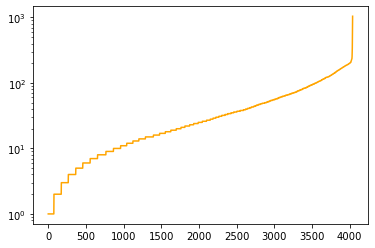

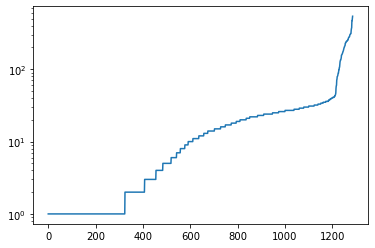

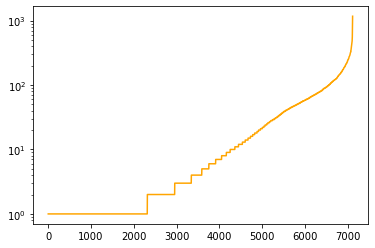

1 1167


In [12]:
def deg_list(G):
    L = []
    for N in G.Nodes():
        L.append(N.GetDeg())
    L.sort()
    return L

def find_N(L,d):
    a = 0
    b = len(L)
    while True:
        N = (a+b)//2
        if L[N]<=d and L[N+1]>d:
            return len(L)-N+1
        elif L[N]>d:
            b = N-1
        else: a = N+1

            
def find_N_d(L,X):
    D = L[-1]
    d = 0
    N = 0
    score = np.inf
    while d<len(L):
        d+=1
        N = find_N(L,d)
        s = N*X + d*D
        if s > score:
            d = d-1
            N = find_N(L,d)
            return d,N,score
        score = s

def find_X(L):
    D = L[-1]
    for X in range(D):
        d,N,score = find_N_d(L,X)
        if score<=X*X:
            return D,X,N,d
        
def find_Nd(L):
        d,N,_ = find_N_d(L,1,1)
        return d,N
    
G5 = snap.LoadEdgeList(snap.TUNGraph, "facebook_combined.txt", 0, 1)
#G1 = snap.GenRMat(4039, 88234, 0.6, 0.1, 0.15)
G1 = snap.LoadEdgeList(snap.TUNGraph, "lastfm4.txt", 0, 1)
N_G = G5.GetNodes()
n = N_G
v5 = 0.006158623641304036
alpha5 = 0.85*v5
Deg5 = np.array(deg_list(G5))
Deg1 = np.array(deg_list(G1))
X5 = [i for i in range(N_G)]
N_1 = len(Deg1)
X1 = [i for i in range(N_1)]
_, ax = plt.subplots()
ax.set_yscale('log')
plt.plot(X5,Deg5,color = 'orange')
plt.show()
_, ax = plt.subplots()
ax.set_yscale('log')
plt.plot(X1,Deg1)
plt.show()
L5,D5 = [i for i in range(N_G)],[i for i in range(N_G)]
L1,D1 = [i for i in range(N_1)],[i for i in range(N_1)]
G3 = snap.LoadEdgeList(snap.TNGraph, "Wiki-Vote.txt", 0, 1)
Deg3 = np.array(deg_list(G3))
v3 = 0.022150996701210627
alpha3 = 0.85*v3
N_3 = len(deg_list(G3))
X3 = [i for i in range(N_3)]
_, ax = plt.subplots()
ax.set_yscale('log')
plt.plot(X3,Deg3,color = 'orange')
plt.show()
L3,D3 = node_convertor(G3)
print(min(Deg3),max(Deg3))

In [13]:
def create_copy(G,t):
    if t=='TUN':
        Gp = snap.TUNGraph.New()
    if t=='TN':
        Gp = snap.TNGraph.New()
    for NI in G.Nodes():
        Gp.AddNode(NI.GetId())
    for EI in G.Edges():
        Gp.AddEdge(EI.GetSrcNId(), EI.GetDstNId())
    return Gp

def create_random_TN(G,eps=1):
    p = 1/(1+np.exp(eps))
    Gp = snap.TNGraph.New()
    for NI in G.Nodes():
        Gp.AddNode(NI.GetId())
    for NI in G.Nodes():
        for N2 in G.Nodes():
            if rd.random()<p:
                Gp.AddEdge(NI.GetId(),N2.GetId())
    for EI in G.Edges():
        Gp.AddEdge(EI.GetSrcNId(), EI.GetDstNId())
        if rd.random()<p:
            Gp.DelEdge(EI.GetSrcNId(), EI.GetDstNId())
    return Gp

def create_random_TUN(G,L,eps=1):
    p = 1/(1+np.exp(eps))
    n = len(list(G.Nodes()))
    visited = np.zeros((n,n))
    visited2 = np.zeros((n,n))
    Gp = snap.TNGraph.New()
    for NI in G.Nodes():
        Gp.AddNode(NI.GetId())
    for NI in G.Nodes():
        for N2 in G.Nodes():
            if not(visited[L[NI.GetId()],L[N2.GetId()]]):
                visited[L[NI.GetId()],L[N2.GetId()]]=1
                visited[L[N2.GetId()],L[NI.GetId()]]=1
                if rd.random()<p:
                    Gp.AddEdge(NI.GetId(),N2.GetId())
    for EI in G.Edges():
        if not(visited2[L[EI.GetSrcNId()], L[EI.GetDstNId()]]):
            visited2[L[EI.GetSrcNId()], L[EI.GetDstNId()]]=1
            visited2[L[EI.GetDstNId()], L[EI.GetSrcNId()]]=1
            Gp.AddEdge(EI.GetSrcNId(), EI.GetDstNId())
            if rd.random()<p:
                Gp.DelEdge(EI.GetSrcNId(), EI.GetDstNId())
                Gp.DelEdge(EI.GetDstNId(), EI.GetSrcNId())
    return Gp

#Gp5 = create_random_TUN(G5,1)
#print(Gp5.GetEdges())
#Gp5 = create_random_TUN(G5,2)
#print(Gp5.GetEdges())


In [14]:
G5b = make_subgraph(G5,400)
G5b.GetNodes()

400

In [15]:
def plot_clipping_step(G,D,L,alpha,X,STEP,ite=60,n_big=10,eps=1):
    n = len(list(G.Nodes()))
    S = len(STEP)
    E1 = [0]*S
    E2 = [0]*S
    B1 = [0]*S
    B2 = [0]*S
    R1 = [0]*S
    R2 = [0]*S
    F1 = [0]*S
    F2 = [0]*S
    r_k = katz_by_graph_exploration(G,D,L,alpha,80,n)
    R_K = [(r_k[i],i) for i in range(n)]
    R_K = sorted(R_K,key = lambda l : l[0],reverse = True)
    M_R = [R_K[i][1] for i in range(n_big)]
    for _ in range(ite):
        for i in range(S):
            f1=0
            f2=0
        
            r_1 = katz_clipping_opt(G,D,L,X,alpha,STEP[i],n,eps)
            r_2 = katz_clipping_local(G,D,L,X,alpha,STEP[i],n,eps)
        
            e1,b1,r1 = loss_bias_error(r_k,r_1,n)
            e2,b2,r2 = loss_bias_error(r_k,r_2,n)
        
            R_1 = [(r_1[i],i) for i in range(len(r_1))]
            R_2 = [(r_2[i],i) for i in range(len(r_2))]
        
            R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
            R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
        
            M1 = [R_1[i][1] for i in range(n_big)]
            M2 = [R_2[i][1] for i in range(n_big)]
        
            for m in M_R:
                if m in M1:
                    f1+=1
                if m in M2:
                    f2+=1
        
            E1[i]+=e1/ite
            E2[i]+=e2/ite
            B1[i]+=b1/ite
            B2[i]+=b2/ite
            R1[i]+=r1/ite
            R2[i]+=r2/ite
            F1[i]+=f1/(n_big*ite)
            F2[i]+=f2/(n_big*ite)
        
    , ax = plt.subplots()
    ax.set_yscale('log')
    plt.plot(STEP,E1,label = 'loss_opt')
    plt.plot(STEP,E2,label = 'loss_local')
    plt.plot(STEP,B1,label = "bias_opt")
    plt.plot(STEP,B2,label = "bias_local")
    plt.legend(loc = 'upper right')
    plt.show()
    plt.clf()

    if False:

        , ax = plt.subplots()
        ax.set_yscale('log')
        plt.plot(X,R1,label = 'err_opt')
        plt.plot(X,R2,label = 'err_local')
        plt.legend(loc = 'lower right')
        plt.show()
        plt.clf()
    
    , ax = plt.subplots()
    ax.set_yscale('log')
    plt.plot(STEP,F1,label = 'freq_opt')
    plt.plot(STEP,F2,label = 'freq_local')
    plt.legend(loc = 'lower right')
    plt.show()
    plt.clf()
    
def plot_clipping_X(G,D,L,alpha,X,STEP,ite=60,n_big=10,eps=1):
    n = len(list(G.Nodes()))
    S = len(X)
    E1 = [0]*S
    E2 = [0]*S
    B1 = [0]*S
    B2 = [0]*S
    R1 = [0]*S
    R2 = [0]*S
    F1 = [0]*S
    F2 = [0]*S
    r_k = katz_by_graph_exploration(G,D,L,alpha,80,n)
    R_K = [(r_k[i],i) for i in range(n)]
    R_K = sorted(R_K,key = lambda l : l[0],reverse = True)
    M_R = [R_K[i][1] for i in range(n_big)]
    for _ in range(ite):
        for i in range(S):
            f1=0
            f2=0
        
            r_1 = katz_clipping_opt(G,D,L,X[i],alpha,STEP,n,eps)
            r_2 = katz_clipping_local(G,D,L,X[i],alpha,STEP,n,eps)
        
            e1,b1,r1 = loss_bias_error(r_k,r_1,n)
            e2,b2,r2 = loss_bias_error(r_k,r_2,n)
        
            R_1 = [(r_1[i],i) for i in range(len(r_1))]
            R_2 = [(r_2[i],i) for i in range(len(r_2))]
        
            R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
            R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
        
            M1 = [R_1[i][1] for i in range(n_big)]
            M2 = [R_2[i][1] for i in range(n_big)]
        
            for m in M_R:
                if m in M1:
                    f1+=1
                if m in M2:
                    f2+=1
        
            E1[i]+=e1/ite
            E2[i]+=e2/ite
            B1[i]+=b1/ite
            B2[i]+=b2/ite
            R1[i]+=r1/ite
            R2[i]+=r2/ite
            F1[i]+=f1/(n_big*ite)
            F2[i]+=f2/(n_big*ite)
        
    , ax = plt.subplots()
    ax.set_yscale('log')
    plt.plot(X,E1,label = 'loss_opt')
    plt.plot(X,E2,label = 'loss_local')
    plt.plot(X,B1,label = "bias_opt")
    plt.plot(X,B2,label = "bias_local")
    plt.legend(loc = 'upper right')
    plt.show()
    plt.clf()
    
    if False:

        , ax = plt.subplots()
        ax.set_yscale('log')
        plt.plot(X,R1,label = 'err_opt')
        plt.plot(X,R2,label = 'err_local')
        plt.legend(loc = 'lower right')
        plt.show()
        plt.clf()
    
    , ax = plt.subplots()
    ax.set_yscale('log')
    plt.plot(X,F1,label = 'freq_opt')
    plt.plot(X,F2,label = 'freq_local')
    plt.legend(loc = 'lower right')
    plt.show()
    plt.clf()

In [16]:
def plot_path(G,D,L,X,STEP,ite=10,eps=1):
    n = len(list(G.Nodes()))
    S = len(STEP)
    STORE1 = np.zeros((S,n,ite))
    L1 = [0]*S
    L2 = [0]*S
    for i in trange(S):
        p_k = count_path(G,D,L,STEP[i],n)
        for j in range(ite):
            p_1 = count_path_clipping(G,D,L,X,STEP[i],n,eps)
            p_2 = count_path_noise(G,D,L,STEP[i],n,eps)
            
            for k in range(n):
                STORE1[i,k,j]=p_1[k]
                
            l1,_,_ = loss_bias_error(p_k,p_1,n)
            l2,_,_ = loss_bias_error(p_k,p_2,n)
            
            L1[i]+=l1/ite
            L2[i]+=l2/ite
    
    var1 = [0]*S
    for i in range(S):
        for k in range(n):
            var1[i]+=np.var(STORE1[i,k,:])/n

    B = [L1[i]-var1[i] for i in range(S)]
    
            
    #plt.plot(STEP,B,color='g')
    plt.plot(STEP,L1,'--s',color='b',label='loss_clipping')
    #plt.plot(STEP,var1,'--o',color='b',label='var_clipping')
    plt.plot(STEP,L2,'--s',color='orange',label='loss_no_clippping')
    #plt.plot(STEP,var2,'--o',color='orange',label='var_no_clipping')
    plt.yscale('log')
    plt.xlabel('Number of steps (S)')
    plt.ylabel('Loss')
    #plt.xticks(STEP)
    plt.legend(loc="upper left")
    #plt.show()
    plt.savefig("path10_facebook.png",dpi=300)
    return L1,L2

In [17]:
G5b = make_subgraph2(G5,400)
G5b.GetNodes()

401

In [19]:
def plot_size(G,SIZE,alpha,X,EPS,graph_type='TUN',ite=10,n_big=10):
    n = len(list(G.Nodes()))
    S = len(SIZE)
    print(EPS)
    store1 = np.zeros((S,ite))
    store2 = np.zeros((S,ite))
    store3 = np.zeros((S,ite))
    store4 = np.zeros((S,ite))
    VAR1 = [0]*S
    VAR2 = [0]*S
    
    F1 = [0]*S
    F2 = [0]*S
    F3 = [0]*S
    F4 = [0]*S
    L1 = [0]*S
    L2 = [0]*S
    E1 = [0]*S
    E2 = [0]*S
    #F3 = [0]*S
    #F4 = [0]*S
    #F5 = [0]*S

    
    for i in trange(S):
        
        n = SIZE[i]         
        
        STORE1 = np.zeros((n,ite))
        STORE2 = np.zeros((n,ite))
        
        
        for j in trange(ite):
            
            G1 = make_subgraph2(G,n)
            N = len(list(G1.Nodes()))
            L,D = node_convertor(G1)
        
            r_k = katz_by_graph_exploration(G1,D,L,alpha,80,N)
            R_K = [(r_k[i],i) for i in range(N)]
            R_K = sorted(R_K,key = lambda l : l[0],reverse = True)
            M_R = [R_K[i][1] for i in range(n_big)]
            M_100 = [R_K[i][1] for i in range(100)]
                
            f1=0
            f2=0
            f3=0
            f4=0
            #f5=0
            
            r_1 = katz_clipping_opt(G1,D,L,X,alpha,10,N,EPS)
            
            if graph_type=='TUN':
                Gp = create_random_TUN(G1,D,EPS)
            if graph_type=='TN':
                Gp = create_random_TN(G1,EPS)
            r_2 = katz_by_graph_exploration(Gp,D,L,alpha,40,N)
            
            #r_2 = katz_clipping_opt(G,D,L,np.inf,alpha,1,n,EPS[i])
            
            for k in range(n):
                STORE1[k,j]=r_1[k]
                STORE2[k,j]=r_2[k]
            
            
            l1,_,e1 = loss_bias_error(r_k,r_1,n)
            l2,_,e2 = loss_bias_error(r_k,r_2,n)
            
            
            #r_3 = katz_by_clipping_noise(G,D,L,X,alpha,STEP[i],i,n_big*eps)
        
            R_1 = [(r_1[i],i) for i in range(len(r_1))]
            R_2 = [(r_2[i],i) for i in range(len(r_2))]
            #R_3 = [(r_3[i],i) for i in range(len(r_3))]
        
            R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
            R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
            #R_3 = sorted(R_3,key=lambda l : l[0],reverse = True)
        
            M1 = [R_1[i][1] for i in range(n_big)]
            M2 = [R_1[i][1] for i in range(100)]
            M3 = [R_2[i][1] for i in range(n_big)]
            M4 = [R_2[i][1] for i in range(100)]
            
            
        
            for m in M_R:
                if m in M1:
                    f1+=0.1
                if m in M3:
                    f3+=0.1
            for m in M_100:
                if m in M2:
                    f2+=0.01
                if m in M4:
                    f4+=0.01
        
            F1[i]+=f1/ite
            F2[i]+=f2/ite
            F3[i]+=f3/ite
            F4[i]+=f4/ite
            L1[i]+=l1/ite
            L2[i]+=l2/ite
            E1[i]+=e1/ite
            E2[i]+=e2/ite
            
            store1[i,j] = f1
            store2[i,j] = f2
            store3[i,j] = f3
            store4[i,j] = f4
            
        for k in range(n):
            VAR1[i]+=np.var(STORE1[k,:])/n
            VAR2[i]+=np.var(STORE2[k,:])/n
        
            
    var1 = []
    var2 = []
    var3 = []
    var4 = []
    for i in range(S):
        var1.append(np.sqrt(np.var(store1[i,:])/ite))
        var2.append(np.sqrt(np.var(store2[i,:])/ite))
        var3.append(np.sqrt(np.var(store3[i,:])/ite))
        var4.append(np.sqrt(np.var(store4[i,:])/ite))
    
    , ax = plt.subplots()
    plt.plot(SIZE,F1,'s',color='b',label = 'top10_clipping',linestyle='dashed')
    plt.errorbar(SIZE,F1,var1,capsize=10, fmt='s', ecolor='black', markeredgecolor = "b", color='b')
    plt.plot(SIZE,F2,'s',color='orange',label = 'top100_clipping',linestyle='dashed')
    plt.errorbar(SIZE,F2,var2,capsize=10, fmt='s', ecolor='black', markeredgecolor = "orange", color='orange')
    plt.plot(SIZE,F3,'o',color='b',label = 'top10_randomized',linestyle='dashed')
    plt.errorbar(SIZE,F3,var3,capsize=10, fmt='o', ecolor='black', markeredgecolor = "b", color='b')
    plt.plot(SIZE,F4,'o',color='orange',label = 'top100_randomized',linestyle='dashed')
    plt.errorbar(SIZE,F4,var4,capsize=10, fmt='o', ecolor='black', markeredgecolor = "orange", color='orange')
    #plt.plot(STEP,F3,label = 'exp2')
    #plt.plot(STEP,F5,label = 'freq_global')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Frequency of detection of top k nodes')
    plt.legend(loc = 'lower left',ncol=2)
    #plt.show()
    plt.savefig("detection_facebook_by_nodes.png",dpi=300)
    plt.clf()
    
    , ax = plt.subplots()
    plt.plot(SIZE,L1,'--s',label = 'loss_clipping',color='b')
    plt.plot(SIZE,VAR1,'--o',label = 'var_clipping',color='b')
    plt.plot(SIZE,L2,'--s',label = 'loss_randomized',color='orange')
    plt.plot(SIZE,VAR2,'--o',label = 'var_randomized',color='orange')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Loss and Variance')
    plt.yscale('log')
    #plt.xticks(STEP)
    plt.legend(loc = 'upper left',ncol=2)
    #plt.show()
    plt.savefig("loss_facebook_by_nodes.png",dpi=300)
    plt.clf()
    
    #, ax = plt.subplots()
    #plt.plot(STEP,E1,'--s',label = 'error_clipping')
    #plt.plot(STEP,E2,'--s',label = 'error_no_clipping')
    #plt.legend(loc = 'upper left')
    #plt.show()
    #plt.clf()
    
    return F1,F2,F3,F4

def plot_radomized_step(G,D,L,alpha,X,STEP,graph_type='TUN',ite=60,n_big=10,eps=1):
    n = len(list(G.Nodes()))
    S = len(STEP)
    store1 = np.zeros((S,ite))
    store2 = np.zeros((S,ite))
    store3 = np.zeros((S,ite))
    store4 = np.zeros((S,ite))
    STORE1 = np.zeros((S,n,ite))
    STORE2 = np.zeros((S,n,ite))
    
    F1 = [0]*S
    F2 = [0]*S
    F3 = [0]*S
    F4 = [0]*S
    L1 = [0]*S
    L2 = [0]*S
    E1 = [0]*S
    E2 = [0]*S
    #F3 = [0]*S
    #F4 = [0]*S
    #F5 = [0]*S
    
    r_k = katz_by_graph_exploration(G,D,L,alpha,80,n)
    R_K = [(r_k[i],i) for i in range(n)]
    R_K = sorted(R_K,key = lambda l : l[0],reverse = True)
    M_R = [R_K[i][1] for i in range(n_big)]
    M_100 = [R_K[i][1] for i in range(100)]
    
    for j in trange(ite):
        for i in range(S):
            f1=0
            f2=0
            f3=0
            f4=0
            #f5=0
        
            r_1 = katz_clipping_opt(G,D,L,X,alpha,STEP[i],n,eps)
            
            if graph_type=='TUN':
                Gp = create_random_TUN(G,D,eps)
            if graph_type=='TN':
                Gp = create_random_TN(G,eps)
            r_2 = katz_by_graph_exploration(Gp,D,L,alpha,STEP[i],n)
            
            for k in range(n):
                STORE1[i,k,j]=r_1[k]
                STORE2[i,k,j]=r_2[k]
            
            
            l1,_,e1 = loss_bias_error(r_k,r_1,n)
            l2,_,e2 = loss_bias_error(r_k,r_2,n)
            
            
            #r_3 = katz_by_clipping_noise(G,D,L,X,alpha,STEP[i],i,n_big*eps)
        
            R_1 = [(r_1[i],i) for i in range(len(r_1))]
            R_2 = [(r_2[i],i) for i in range(len(r_2))]
            #R_3 = [(r_3[i],i) for i in range(len(r_3))]
        
            R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
            R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
            #R_3 = sorted(R_3,key=lambda l : l[0],reverse = True)
        
            M1 = [R_1[i][1] for i in range(n_big)]
            M2 = [R_1[i][1] for i in range(100)]
            M3 = [R_2[i][1] for i in range(n_big)]
            M4 = [R_2[i][1] for i in range(100)]
            
            
        
            for m in M_R:
                if m in M1:
                    f1+=0.1
                if m in M3:
                    f3+=0.1
            for m in M_100:
                if m in M2:
                    f2+=0.01
                if m in M4:
                    f4+=0.01
        
            F1[i]+=f1/ite
            F2[i]+=f2/ite
            F3[i]+=f3/ite
            F4[i]+=f4/ite
            L1[i]+=l1/ite
            L2[i]+=l2/ite
            E1[i]+=e1/ite
            E2[i]+=e2/ite
            
            store1[i,j] = f1
            store2[i,j] = f2
            store3[i,j] = f3
            store4[i,j] = f4
            
    var1 = []
    var2 = []
    var3 = []
    var4 = []
    for i in range(S):
        var1.append(np.sqrt(np.var(store1[i,:])/ite))
        var2.append(np.sqrt(np.var(store2[i,:])/ite))
        var3.append(np.sqrt(np.var(store3[i,:])/ite))
        var4.append(np.sqrt(np.var(store4[i,:])/ite))
        
    VAR1 = [0]*S
    VAR2 = [0]*S
    for i in range(S):
        for k in range(n):
            VAR1[i]+=np.var(STORE1[i,k,:])/n
            VAR2[i]+=np.var(STORE2[i,k,:])/n
    
    , ax = plt.subplots()
    plt.plot(STEP,F1,'s',color='b',label = 'top10_clipping',linestyle='dashed')
    plt.errorbar(STEP,F1,var1,capsize=10, fmt='s', ecolor='black', markeredgecolor = "b", color='b')
    plt.plot(STEP,F2,'s',color='orange',label = 'top100_clipping',linestyle='dashed')
    plt.errorbar(STEP,F2,var2,capsize=10, fmt='s', ecolor='black', markeredgecolor = "orange", color='orange')
    plt.plot(STEP,F3,'o',color='b',label = 'top10_randomized',linestyle='dashed')
    plt.errorbar(STEP,F3,var3,capsize=10, fmt='o', ecolor='black', markeredgecolor = "b", color='b')
    plt.plot(STEP,F4,'o',color='orange',label = 'top100_randomized',linestyle='dashed')
    plt.errorbar(STEP,F4,var4,capsize=10, fmt='o', ecolor='black', markeredgecolor = "orange", color='orange')
    #plt.plot(STEP,F3,label = 'exp2')
    #plt.plot(STEP,F5,label = 'freq_global')
    plt.xlabel('Number of steps (S)')
    plt.ylabel('Frequency of detection of top k nodes')
    plt.legend(loc = 'lower left',ncol=2)
    #plt.show()
    plt.savefig("detection_wiki_randomized.png",dpi=300)
    plt.clf()
    
    , ax = plt.subplots()
    plt.plot(STEP,L1,'--s',label = 'loss_clipping',color='b')
    plt.plot(STEP,VAR1,'--o',label = 'var_clipping',color='b')
    plt.plot(STEP,L2,'--s',label = 'loss_randomized',color='orange')
    plt.plot(STEP,VAR2,'--o',label = 'var_randomized',color='orange')
    plt.xlabel('Number of steps (S)')
    plt.ylabel('Loss and Variance')
    plt.yscale('log')
    #plt.xticks(STEP)
    plt.legend(loc = 'lower right',ncol=2)
    #plt.show()
    plt.savefig("loss_wiki_randomized.png",dpi=300)
    plt.clf()
    
    , ax = plt.subplots()
    plt.plot(STEP,E1,'--s',label = 'error_clipping')
    plt.plot(STEP,E2,'--s',label = 'error_no_clipping')
    plt.legend(loc = 'upper left')
    plt.show()
    plt.clf()
    
    return F1,F2,F3,F4

In [23]:
SIZE = [800*i for i in range(1,6)]
F1,F2,F3,F4 = plot_size(G5,SIZE,alpha5,1/alpha5,2,graph_type='TUN',ite=40,n_big=10)

2


<Figure size 432x288 with 0 Axes>

In [20]:
SIZE = [800*i for i in range(1,6)]
F1,F2,F3,F4 = plot_size(G5,SIZE,alpha5,1/alpha5,2,graph_type='TUN',ite=3,n_big=10)

2


<Figure size 432x288 with 0 Axes>

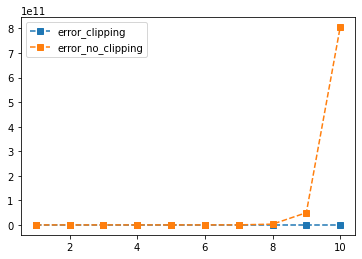

<Figure size 432x288 with 0 Axes>

In [46]:
STEP = [i for i in range(1,11)]
F1,F2,F3,F4 = plot_radomized_step(G3,D3,L3,alpha3,1/alpha3,STEP,ite=6,n_big=10,eps=2,graph_type='TN')

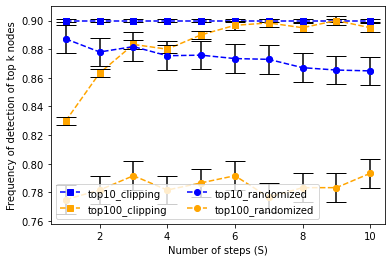

In [67]:
var1 = [0.001]*10
var2 = [0.003]*10
var3 = [0.01]*10
var4 = [0.01]*10
, ax = plt.subplots()
plt.plot(STEP,F1,'s',color='b',label = 'top10_clipping',linestyle='dashed')
plt.errorbar(STEP,F1,var1,capsize=10, fmt='s', ecolor='black', markeredgecolor = "b", color='b')
plt.plot(STEP,F2,'s',color='orange',label = 'top100_clipping',linestyle='dashed')
plt.errorbar(STEP,F2,var2,capsize=10, fmt='s', ecolor='black', markeredgecolor = "orange", color='orange')
plt.plot(STEP,F3b,'o',color='b',label = 'top10_randomized',linestyle='dashed')
plt.errorbar(STEP,F3b,var3,capsize=10, fmt='o', ecolor='black', markeredgecolor = "b", color='b')
plt.plot(STEP,F4,'o',color='orange',label = 'top100_randomized',linestyle='dashed')
plt.errorbar(STEP,F4,var4,capsize=10, fmt='o', ecolor='black', markeredgecolor = "orange", color='orange')
    #plt.plot(STEP,F3,label = 'exp2')
    #plt.plot(STEP,F5,label = 'freq_global')
plt.xlabel('Number of steps (S)')
plt.ylabel('Frequency of detection of top k nodes')
plt.legend(loc = 'lower left',ncol=2)
plt.savefig("detection_wiki_randomized.png",dpi=300)

In [65]:
print(F3)
F3b = [0.88*(1-i/10)+0.86*i/10 + 0.01*np.random.random() for i in range(10)]
print(F3b)

[0.9, 0.8666666666666667, 0.9, 0.8833333333333333, 0.85, 0.9, 0.8833333333333334, 0.9, 0.8666666666666667, 0.8833333333333334]
[0.8872005326420193, 0.8780399403191712, 0.881798225332154, 0.8754474322440177, 0.8758332458624545, 0.8734525592239619, 0.8729165210147464, 0.8671001882884497, 0.8654386227284852, 0.8648478866474529]


In [15]:
Gp = create_random_TUN(G5,D5,2)

In [17]:
r_k = katz_by_graph_exploration(G5,D5,L5,alpha5,40,n)

In [18]:
r_1 = katz_by_graph_exploration(Gp,D5,L5,alpha5,1,n)

In [28]:
print(np.mean(r_k))
print(np.mean(r_k1))
print(np.mean(r_1))
print(np.mean(r_2))

0.698094550033857
0.22871502778499495
1.3476207544717134
4.495079943453373


In [27]:
r_2 = katz_by_graph_exploration(Gp,D5,L5,alpha5,5,n)

In [37]:
r_3 = biggest_degree(G5,L5,n)
R_1 = [(r_k1[i],i) for i in range(len(r_k))]
R_2 = [(r_1[i],i) for i in range(len(r_2))]
R_3 = [(r_3[i],i) for i in range(len(r_3))]
        
R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
R_3 = sorted(R_3,key=lambda l : l[0],reverse = True)
        
M1 = [R_1[i][1] for i in range(10)]
M2 = [R_2[i][1] for i in range(10)]
M3 = [R_3[i][1] for i in range(10)]
print(M1)
print(M2)
print(M3)

[107, 1684, 1912, 3437, 0, 2543, 2347, 1888, 1800, 1663]
[107, 1684, 1912, 0, 3437, 348, 946, 136, 483, 917]
[107, 1684, 1912, 3437, 0, 2543, 2347, 1888, 1800, 2266]


In [154]:
SIZE = [400*i for i in range(1,11)]
F1,F2,F3,F4 = plot_size(G5,SIZE,alpha5,1/alpha5,2)

2


<Figure size 432x288 with 0 Axes>

In [10]:
def plot_compare(G,D,L,alpha,X,EPS,graph_type='TUN',ite=60,n_big=10):
    n = len(list(G.Nodes()))
    S = len(EPS)
    store1 = np.zeros((S,ite))
    store2 = np.zeros((S,ite))
    store3 = np.zeros((S,ite))
    store4 = np.zeros((S,ite))
    STORE1 = np.zeros((S,n,ite))
    STORE2 = np.zeros((S,n,ite))
    
    F1 = [0]*S
    F2 = [0]*S
    F3 = [0]*S
    F4 = [0]*S
    L1 = [0]*S
    L2 = [0]*S
    E1 = [0]*S
    E2 = [0]*S
    #F3 = [0]*S
    #F4 = [0]*S
    #F5 = [0]*S
    
    r_k = katz_by_graph_exploration(G,D,L,alpha,80,n)
    R_K = [(r_k[i],i) for i in range(n)]
    R_K = sorted(R_K,key = lambda l : l[0],reverse = True)
    M_R = [R_K[i][1] for i in range(n_big)]
    M_100 = [R_K[i][1] for i in range(100)]
    
    for i in trange(S):
        for j in trange(ite):
            f1=0
            f2=0
            f3=0
            f4=0
            #f5=0
            
            r_1 = katz_clipping_opt(G,D,L,X,alpha,10,n,EPS[i])
            
            if graph_type=='TUN':
                Gp = create_random_TUN(G,EPS[i])
            if graph_type=='TN':
                Gp = create_random_TN(G,EPS[i])
            r_2 = katz_by_graph_exploration(Gp,D,L,alpha,40,n)
            
            #r_2 = katz_clipping_opt(G,D,L,np.inf,alpha,1,n,EPS[i])
            
            for k in range(n):
                STORE1[i,k,j]=r_1[k]
                STORE2[i,k,j]=r_2[k]
            
            
            l1,_,e1 = loss_bias_error(r_k,r_1,n)
            l2,_,e2 = loss_bias_error(r_k,r_2,n)
            
            
            #r_3 = katz_by_clipping_noise(G,D,L,X,alpha,STEP[i],i,n_big*eps)
        
            R_1 = [(r_1[i],i) for i in range(len(r_1))]
            R_2 = [(r_2[i],i) for i in range(len(r_2))]
            #R_3 = [(r_3[i],i) for i in range(len(r_3))]
        
            R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
            R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
            #R_3 = sorted(R_3,key=lambda l : l[0],reverse = True)
        
            M1 = [R_1[i][1] for i in range(n_big)]
            M2 = [R_1[i][1] for i in range(100)]
            M3 = [R_2[i][1] for i in range(n_big)]
            M4 = [R_2[i][1] for i in range(100)]
            
            
        
            for m in M_R:
                if m in M1:
                    f1+=0.1
                if m in M3:
                    f3+=0.1
            for m in M_100:
                if m in M2:
                    f2+=0.01
                if m in M4:
                    f4+=0.01
        
            F1[i]+=f1/ite
            F2[i]+=f2/ite
            F3[i]+=f3/ite
            F4[i]+=f4/ite
            L1[i]+=l1/ite
            L2[i]+=l2/ite
            E1[i]+=e1/ite
            E2[i]+=e2/ite
            
            store1[i,j] = f1
            store2[i,j] = f2
            store3[i,j] = f3
            store4[i,j] = f4
            
    var1 = []
    var2 = []
    var3 = []
    var4 = []
    for i in range(S):
        var1.append(np.sqrt(np.var(store1[i,:])/ite))
        var2.append(np.sqrt(np.var(store2[i,:])/ite))
        var3.append(np.sqrt(np.var(store3[i,:])/ite))
        var4.append(np.sqrt(np.var(store4[i,:])/ite))
        
    VAR1 = [0]*S
    VAR2 = [0]*S
    for i in range(S):
        for k in range(n):
            VAR1[i]+=np.var(STORE1[i,k,:])/n
            VAR2[i]+=np.var(STORE2[i,k,:])/n
    
    , ax = plt.subplots()
    plt.plot(EPS,F1,'s',color='b',label = 'top10_clipping',linestyle='dashed')
    plt.errorbar(EPS,F1,var1,capsize=10, fmt='s', ecolor='black', markeredgecolor = "b", color='b')
    plt.plot(EPS,F2,'s',color='orange',label = 'top100_clipping',linestyle='dashed')
    plt.errorbar(EPS,F2,var2,capsize=10, fmt='s', ecolor='black', markeredgecolor = "orange", color='orange')
    plt.plot(EPS,F3,'o',color='b',label = 'top10_randomized',linestyle='dashed')
    plt.errorbar(EPS,F3,var3,capsize=10, fmt='o', ecolor='black', markeredgecolor = "b", color='b')
    plt.plot(EPS,F4,'o',color='orange',label = 'top100_randomized',linestyle='dashed')
    plt.errorbar(EPS,F4,var4,capsize=10, fmt='o', ecolor='black', markeredgecolor = "orange", color='orange')
    #plt.plot(STEP,F3,label = 'exp2')
    #plt.plot(STEP,F5,label = 'freq_global')
    plt.xlabel('Epsilon')
    plt.ylabel('Frequency of detection of top k nodes')
    plt.legend(loc = 'lower left',ncol=2)
    plt.show()
    #plt.savefig("detection_vs_randomized_wiki_bis.png",dpi=300)
    plt.clf()
    
    , ax = plt.subplots()
    plt.plot(EPS,L1,'--s',label = 'loss_clipping',color='b')
    plt.plot(EPS,VAR1,'--o',label = 'var_clipping',color='b')
    plt.plot(EPS,L2,'--s',label = 'loss_randomized',color='orange')
    plt.plot(EPS,VAR2,'--o',label = 'var_randomized',color='orange')
    plt.xlabel('Epsilon')
    plt.ylabel('Loss and Variance')
    plt.yscale('log')
    #plt.xticks(STEP)
    plt.legend(loc = 'upper left',ncol=2)
    plt.show()
    #plt.savefig("loss_vs_randomized_wiki_bis.png",dpi=300)
    plt.clf()
    
    #, ax = plt.subplots()
    #plt.plot(STEP,E1,'--s',label = 'error_clipping')
    #plt.plot(STEP,E2,'--s',label = 'error_no_clipping')
    #plt.legend(loc = 'upper left')
    #plt.show()
    #plt.clf()
    
    return F1,F2,L1,L2,VAR1,VAR2

def plot_clipping_step(G,D,L,alpha,X,STEP,ite=60,n_big=10,eps=1):
    n = len(list(G.Nodes()))
    S = len(STEP)
    store1 = np.zeros((S,ite))
    store2 = np.zeros((S,ite))
    store3 = np.zeros((S,ite))
    store4 = np.zeros((S,ite))
    STORE1 = np.zeros((S,n,ite))
    STORE2 = np.zeros((S,n,ite))
    
    F1 = [0]*S
    F2 = [0]*S
    F3 = [0]*S
    F4 = [0]*S
    L1 = [0]*S
    L2 = [0]*S
    E1 = [0]*S
    E2 = [0]*S
    #F3 = [0]*S
    #F4 = [0]*S
    #F5 = [0]*S
    
    r_k = katz_by_graph_exploration(G,D,L,alpha,80,n)
    R_K = [(r_k[i],i) for i in range(n)]
    R_K = sorted(R_K,key = lambda l : l[0],reverse = True)
    M_R = [R_K[i][1] for i in range(n_big)]
    M_100 = [R_K[i][1] for i in range(100)]
    
    for j in trange(ite):
        for i in range(S):
            f1=0
            f2=0
            f3=0
            f4=0
            #f5=0
        
            r_1 = katz_clipping_opt(G,D,L,X,alpha,STEP[i],n,eps)
            r_2 = katz_without_clipping(G,D,L,alpha,STEP[i],n,eps)
            for k in range(n):
                STORE1[i,k,j]=r_1[k]
                STORE2[i,k,j]=r_2[k]
            
            
            l1,_,e1 = loss_bias_error(r_k,r_1,n)
            l2,_,e2 = loss_bias_error(r_k,r_2,n)
            
            
            #r_3 = katz_by_clipping_noise(G,D,L,X,alpha,STEP[i],i,n_big*eps)
        
            R_1 = [(r_1[i],i) for i in range(len(r_1))]
            R_2 = [(r_2[i],i) for i in range(len(r_2))]
            #R_3 = [(r_3[i],i) for i in range(len(r_3))]
        
            R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
            R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
            #R_3 = sorted(R_3,key=lambda l : l[0],reverse = True)
        
            M1 = [R_1[i][1] for i in range(n_big)]
            M2 = [R_1[i][1] for i in range(100)]
            M3 = [R_2[i][1] for i in range(n_big)]
            M4 = [R_2[i][1] for i in range(100)]
            
            
        
            for m in M_R:
                if m in M1:
                    f1+=0.1
                if m in M3:
                    f3+=0.1
            for m in M_100:
                if m in M2:
                    f2+=0.01
                if m in M4:
                    f4+=0.01
        
            F1[i]+=f1/ite
            F2[i]+=f2/ite
            F3[i]+=f3/ite
            F4[i]+=f4/ite
            L1[i]+=l1/ite
            L2[i]+=l2/ite
            E1[i]+=e1/ite
            E2[i]+=e2/ite
            
            store1[i,j] = f1
            store2[i,j] = f2
            store3[i,j] = f3
            store4[i,j] = f4
            
    var1 = []
    var2 = []
    var3 = []
    var4 = []
    for i in range(S):
        var1.append(np.sqrt(np.var(store1[i,:])/ite))
        var2.append(np.sqrt(np.var(store2[i,:])/ite))
        var3.append(np.sqrt(np.var(store3[i,:])/ite))
        var4.append(np.sqrt(np.var(store4[i,:])/ite))
        
    VAR1 = [0]*S
    VAR2 = [0]*S
    for i in range(S):
        for k in range(n):
            VAR1[i]+=np.var(STORE1[i,k,:])/n
            VAR2[i]+=np.var(STORE2[i,k,:])/n
    
    , ax = plt.subplots()
    plt.plot(STEP,F1,'s',color='b',label = 'top10_clipping',linestyle='dashed')
    plt.errorbar(STEP,F1,var1,capsize=10, fmt='s', ecolor='black', markeredgecolor = "b", color='b')
    plt.plot(STEP,F2,'s',color='orange',label = 'top100_clipping',linestyle='dashed')
    plt.errorbar(STEP,F2,var2,capsize=10, fmt='s', ecolor='black', markeredgecolor = "orange", color='orange')
    plt.plot(STEP,F3,'o',color='b',label = 'top10_no_clipping',linestyle='dashed')
    plt.errorbar(STEP,F3,var3,capsize=10, fmt='o', ecolor='black', markeredgecolor = "b", color='b')
    plt.plot(STEP,F4,'o',color='orange',label = 'top100_no_clipping',linestyle='dashed')
    plt.errorbar(STEP,F4,var4,capsize=10, fmt='o', ecolor='black', markeredgecolor = "orange", color='orange')
    #plt.plot(STEP,F3,label = 'exp2')
    #plt.plot(STEP,F5,label = 'freq_global')
    plt.xlabel('Number of steps (S)')
    plt.ylabel('Frequency of detection of top k nodes')
    plt.legend(loc = 'lower left',ncol=2)
    plt.show()
    #plt.savefig("loss_step_wiki.png",dpi=300)
    plt.clf()
    
    , ax = plt.subplots()
    plt.plot(STEP,L1,'--s',label = 'loss_clipping',color='b')
    plt.plot(STEP,VAR1,'--o',label = 'var_clipping',color='b')
    plt.plot(STEP,L2,'--s',label = 'loss_no_clipping',color='orange')
    plt.plot(STEP,VAR2,'--o',label = 'var_no_clipping',color='orange')
    plt.xlabel('Number of steps (S)')
    plt.ylabel('Loss and Variance')
    plt.yscale('log')
    #plt.xticks(STEP)
    plt.legend(loc = 'upper left',ncol=2)
    plt.show()
    #plt.savefig("detection_step_wiki.png",dpi=300)
    plt.clf()
    
    , ax = plt.subplots()
    plt.plot(STEP,E1,'--s',label = 'error_clipping')
    plt.plot(STEP,E2,'--s',label = 'error_no_clipping')
    plt.legend(loc = 'upper left')
    plt.show()
    plt.clf()
    
    return F1,F2
    
def plot_clipping_X(G,D,L,alpha,X,STEP,ite=60,n_big=10,eps=1):
    n = len(list(G.Nodes()))
    S = len(X)
    store1 = np.zeros((S,ite))
    store2 = np.zeros((S,ite))
    STORE = np.zeros((S,n,ite))
    
    F1 = [0]*S
    F2 = [0]*S
    L1 = [0]*S
    #F3 = [0]*S
    #F4 = [0]*S
    #F5 = [0]*S
    
    r_k = katz_by_graph_exploration(G,D,L,alpha,80,n)
    R_K = [(r_k[i],i) for i in range(n)]
    R_K = sorted(R_K,key = lambda l : l[0],reverse = True)
    M_R = [R_K[i][1] for i in range(n_big)]
    M_100 = [R_K[i][1] for i in range(100)]
    
    for j in trange(ite):
        for i in range(S):
            f1=0
            f2=0
            #f3=0
            #f4=0
            #f5=0
        
            r_1 = katz_clipping_opt(G,D,L,X[i],alpha,STEP,n,eps)
            #r_2 = katz_clipping_local(G,D,L,X[i],alpha,STEP,n,eps)
            #r_3 = katz_by_clipping_noise(G,D,L,X[i],alpha,STEP,n,n_big*eps)
            for k in range(n):
                STORE[i,k,j]=r_1[k]
            
        
            R_1 = [(r_1[i],i) for i in range(len(r_1))]
            #R_2 = [(r_2[i],i) for i in range(len(r_2))]
            #R_3 = [(r_3[i],i) for i in range(len(r_3))]
        
            R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
            #R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
            #R_3 = sorted(R_3,key=lambda l : l[0],reverse = True)
        
            M1 = [R_1[i][1] for i in range(n_big)]
            M2 = [R_1[i][1] for i in range(100)]
            #M2 = [R_2[i][1] for i in range(n_big)]
            #M5 = [R_3[i][1] for i in range(n_big)]
            
            #M2 = exponential(G,D,L,X[i],alpha,STEP,n_big,n,eps)
            #M3 = expo2(G,D,L,X[i],alpha,STEP,n_big,n,eps)
        
            for m in M_R:
                if m in M1:
                    f1+=0.1
            for m in M_100:
                if m in M2:
                    f2+=0.01
                    
            l,_,_ = loss_bias_error(r_k,r_1,n)
            L1[i]+=l/ite

            F1[i]+=f1/ite
            F2[i]+=f2/ite
            store1[i,j]=f1
            store2[i,j]=f2
            #F3[i]+=f3/(n_big*ite)
            #F4[i]+=f4/(n_big*ite)
            #F5[i]+=f5/(n_big*ite)
            
    var1 = []
    var2 = []
    for i in range(S):
        var1.append(np.sqrt(np.var(store1[i,:])/ite))
        var2.append(np.sqrt(np.var(store2[i,:])/ite))
        
    VAR = [0]*S
    for i in range(S):
        for k in range(n):
            VAR[i]+=np.var(STORE[i,k,:])/n
    
    , ax = plt.subplots()
    ax.set_yscale('log')
    plt.plot(X,F1,'s',color='b',label = 'top10',linestyle='dashed')
    plt.errorbar(X,F1,var1,capsize=10, fmt='s', ecolor='black', markeredgecolor = "b", color='b')
    #plt.plot(X,F2,label = 'freq_local')
    plt.plot(X,F2,'s',color='orange',label = 'top100',linestyle='dashed')
    plt.errorbar(X,F2,var2,capsize=10, fmt='s', ecolor='black', markeredgecolor = "orange", color='orange')
    #plt.plot(X,F3,label = 'freq_exp2')
    #plt.plot(X,F5,label = 'freq_global')
    plt.xlabel('Clipping factor (X)')
    plt.ylabel('Frequency of detection of top k nodes')
    plt.legend(loc = 'lower right')
    plt.savefig("detection_clipping_wiki.png",dpi=300)
    plt.clf()
    #print(store1)
    
    , ax = plt.subplots()
    plt.plot(X,L1,'--s',label = 'loss',color='b')
    plt.plot(X,VAR,'--o',label = 'variance',color='b')
    plt.xlabel('Clipping factor (X)')
    plt.ylabel('Loss and Variance')
    plt.legend(loc = 'upper right')
    plt.savefig("loss_clipping_wiki.png",dpi=300)
    plt.clf()


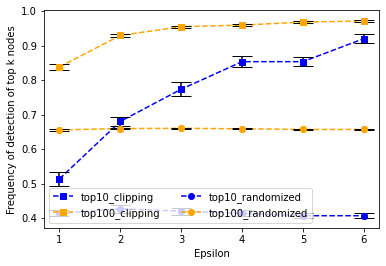

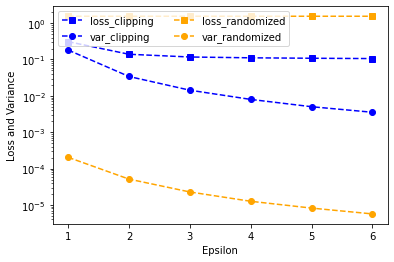

<Figure size 432x288 with 0 Axes>

In [51]:
EPS = [1,2,3,4,5,6]
F1,F2,L1,L2,VAR1,VAR2 = plot_compare(G5,D5,L5,alpha5,1/alpha5,EPS,graph_type='None',ite=15)

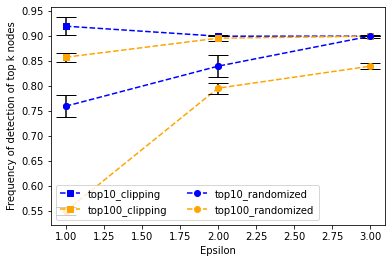

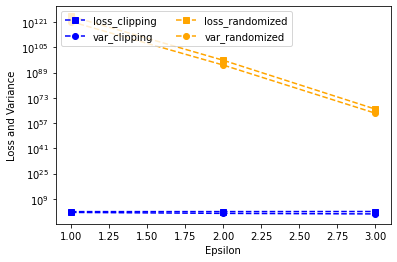

<Figure size 432x288 with 0 Axes>

In [10]:
EPS = [1,2,3]
F1,F2,L1,L2,VAR1,VAR2 = plot_compare(G3,D3,L3,alpha3,1/alpha3,EPS,graph_type='TN',ite=5)

In [12]:
print(F1)
print(F2)
print(L1)
print(L2)
print(VAR1)
print(VAR2)
print([L2[i]/VAR2[i] for i in range(3)])

[0.9199999999999999, 0.8999999999999999, 0.8999999999999999]
[0.8580000000000005, 0.8960000000000006, 0.9000000000000006]
[7.201222597478521, 7.4622623081432335, 8.501101237440961]
[4.788840975687383e+124, 6.194972254669073e+96, 6.77394065998011e+65]
[2.2657902868620994, 0.5576418906250586, 0.25175291565987207]
[1.869927228079236e+121, 5.8194761523736515e+93, 1.681609167844167e+63]
[2560.9771887253683, 1064.524038326416, 402.8249125606482]


In [7]:
def plot_compare(G,D,L,alpha,X,EPS,graph_type='TUN',ite=60,n_big=10):
    n = len(list(G.Nodes()))
    S = len(EPS)
    store1 = np.zeros((S,ite))
    store2 = np.zeros((S,ite))
    store3 = np.zeros((S,ite))
    store4 = np.zeros((S,ite))
    STORE1 = np.zeros((S,n,ite))
    STORE2 = np.zeros((S,n,ite))
    
    F1 = [0]*S
    F2 = [0]*S
    F3 = [0]*S
    F4 = [0]*S
    L1 = [0]*S
    L2 = [0]*S
    E1 = [0]*S
    E2 = [0]*S
    #F3 = [0]*S
    #F4 = [0]*S
    #F5 = [0]*S
    
    r_k = katz_by_graph_exploration(G,D,L,alpha,80,n)
    R_K = [(r_k[i],i) for i in range(n)]
    R_K = sorted(R_K,key = lambda l : l[0],reverse = True)
    M_R = [R_K[i][1] for i in range(n_big)]
    M_100 = [R_K[i][1] for i in range(100)]
    
    for i in trange(S):
        for j in trange(ite):
            f1=0
            f2=0
            f3=0
            f4=0
            #f5=0
            
            r_1 = katz_clipping_opt(G,D,L,X,alpha,10,n,EPS[i])
            
            if graph_type=='TUN':
                Gp = create_random_TUN(G,EPS[i])
            if graph_type=='TN':
                Gp = create_random_TN(G,EPS[i])
            r_2 = katz_by_graph_exploration(Gp,D,L,alpha,40,n)
            
            #r_2 = katz_clipping_opt(G,D,L,np.inf,alpha,1,n,EPS[i])
            
            for k in range(n):
                STORE1[i,k,j]=r_1[k]
                STORE2[i,k,j]=r_2[k]
            
            
            l1,_,e1 = loss_bias_error(r_k,r_1,n)
            l2,_,e2 = loss_bias_error(r_k,r_2,n)
            
            
            #r_3 = katz_by_clipping_noise(G,D,L,X,alpha,STEP[i],i,n_big*eps)
        
            R_1 = [(r_1[i],i) for i in range(len(r_1))]
            R_2 = [(r_2[i],i) for i in range(len(r_2))]
            #R_3 = [(r_3[i],i) for i in range(len(r_3))]
        
            R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
            R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
            #R_3 = sorted(R_3,key=lambda l : l[0],reverse = True)
        
            M1 = [R_1[i][1] for i in range(n_big)]
            M2 = [R_1[i][1] for i in range(100)]
            M3 = [R_2[i][1] for i in range(n_big)]
            M4 = [R_2[i][1] for i in range(100)]
            
            
        
            for m in M_R:
                if m in M1:
                    f1+=0.1
                if m in M3:
                    f3+=0.1
            for m in M_100:
                if m in M2:
                    f2+=0.01
                if m in M4:
                    f4+=0.01
        
            F1[i]+=f1/ite
            F2[i]+=f2/ite
            F3[i]+=f3/ite
            F4[i]+=f4/ite
            L1[i]+=l1/ite
            L2[i]+=l2/ite
            E1[i]+=e1/ite
            E2[i]+=e2/ite
            
            store1[i,j] = f1
            store2[i,j] = f2
            store3[i,j] = f3
            store4[i,j] = f4
            
    var1 = []
    var2 = []
    var3 = []
    var4 = []
    for i in range(S):
        var1.append(np.sqrt(np.var(store1[i,:])/ite))
        var2.append(np.sqrt(np.var(store2[i,:])/ite))
        var3.append(np.sqrt(np.var(store3[i,:])/ite))
        var4.append(np.sqrt(np.var(store4[i,:])/ite))
        
    VAR1 = [0]*S
    VAR2 = [0]*S
    for i in range(S):
        for k in range(n):
            VAR1[i]+=np.var(STORE1[i,k,:])/n
            VAR2[i]+=np.var(STORE2[i,k,:])/n
    
    , ax = plt.subplots()
    plt.plot(EPS,F1,'s',color='b',label = 'top10_clipping',linestyle='dashed')
    plt.errorbar(EPS,F1,var1,capsize=10, fmt='s', ecolor='black', markeredgecolor = "b", color='b')
    plt.plot(EPS,F2,'s',color='orange',label = 'top100_clipping',linestyle='dashed')
    plt.errorbar(EPS,F2,var2,capsize=10, fmt='s', ecolor='black', markeredgecolor = "orange", color='orange')
    plt.plot(EPS,F3,'o',color='b',label = 'top10_randomized',linestyle='dashed')
    plt.errorbar(EPS,F3,var3,capsize=10, fmt='o', ecolor='black', markeredgecolor = "b", color='b')
    plt.plot(EPS,F4,'o',color='orange',label = 'top100_randomized',linestyle='dashed')
    plt.errorbar(EPS,F4,var4,capsize=10, fmt='o', ecolor='black', markeredgecolor = "orange", color='orange')
    #plt.plot(STEP,F3,label = 'exp2')
    #plt.plot(STEP,F5,label = 'freq_global')
    plt.xlabel('Epsilon')
    plt.ylabel('Frequency of detection of top k nodes')
    plt.legend(loc = 'lower left',ncol=2)
    plt.show()
    #plt.savefig("detection_vs_randomized_wiki_bis.png",dpi=300)
    plt.clf()
    
    , ax = plt.subplots()
    plt.plot(EPS,L1,'--s',label = 'loss_clipping',color='b')
    plt.plot(EPS,VAR1,'--o',label = 'var_clipping',color='b')
    plt.plot(EPS,L2,'--s',label = 'loss_randomized',color='orange')
    plt.plot(EPS,VAR2,'--o',label = 'var_randomized',color='orange')
    plt.xlabel('Epsilon')
    plt.ylabel('Loss and Variance')
    plt.yscale('log')
    #plt.xticks(STEP)
    plt.legend(loc = 'upper left',ncol=2)
    plt.show()
    #plt.savefig("loss_vs_randomized_wiki_bis.png",dpi=300)
    plt.clf()
    
    #, ax = plt.subplots()
    #plt.plot(STEP,E1,'--s',label = 'error_clipping')
    #plt.plot(STEP,E2,'--s',label = 'error_no_clipping')
    #plt.legend(loc = 'upper left')
    #plt.show()
    #plt.clf()
    
    return F1,F2,L1,L2,VAR1,VAR2

def plot_clipping_step(G,D,L,alpha,X,STEP,ite=60,n_big=10,eps=1):
    n = len(list(G.Nodes()))
    S = len(STEP)
    store1 = np.zeros((S,ite))
    store2 = np.zeros((S,ite))
    store3 = np.zeros((S,ite))
    store4 = np.zeros((S,ite))
    STORE1 = np.zeros((S,n,ite))
    STORE2 = np.zeros((S,n,ite))
    
    F1 = [0]*S
    F2 = [0]*S
    F3 = [0]*S
    F4 = [0]*S
    L1 = [0]*S
    L2 = [0]*S
    E1 = [0]*S
    E2 = [0]*S
    #F3 = [0]*S
    #F4 = [0]*S
    #F5 = [0]*S
    
    r_k = katz_by_graph_exploration(G,D,L,alpha,80,n)
    R_K = [(r_k[i],i) for i in range(n)]
    R_K = sorted(R_K,key = lambda l : l[0],reverse = True)
    M_R = [R_K[i][1] for i in range(n_big)]
    M_100 = [R_K[i][1] for i in range(100)]
    
    for j in trange(ite):
        for i in range(S):
            f1=0
            f2=0
            f3=0
            f4=0
            #f5=0
        
            r_1 = katz_clipping_opt(G,D,L,X,alpha,STEP[i],n,eps)
            r_2 = katz_without_clipping(G,D,L,alpha,STEP[i],n,eps)
            for k in range(n):
                STORE1[i,k,j]=r_1[k]
                STORE2[i,k,j]=r_2[k]
            
            
            l1,_,e1 = loss_bias_error(r_k,r_1,n)
            l2,_,e2 = loss_bias_error(r_k,r_2,n)
            
            
            #r_3 = katz_by_clipping_noise(G,D,L,X,alpha,STEP[i],i,n_big*eps)
        
            R_1 = [(r_1[i],i) for i in range(len(r_1))]
            R_2 = [(r_2[i],i) for i in range(len(r_2))]
            #R_3 = [(r_3[i],i) for i in range(len(r_3))]
        
            R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
            R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
            #R_3 = sorted(R_3,key=lambda l : l[0],reverse = True)
        
            M1 = [R_1[i][1] for i in range(n_big)]
            M2 = [R_1[i][1] for i in range(100)]
            M3 = [R_2[i][1] for i in range(n_big)]
            M4 = [R_2[i][1] for i in range(100)]
            
            
        
            for m in M_R:
                if m in M1:
                    f1+=0.1
                if m in M3:
                    f3+=0.1
            for m in M_100:
                if m in M2:
                    f2+=0.01
                if m in M4:
                    f4+=0.01
        
            F1[i]+=f1/ite
            F2[i]+=f2/ite
            F3[i]+=f3/ite
            F4[i]+=f4/ite
            L1[i]+=l1/ite
            L2[i]+=l2/ite
            E1[i]+=e1/ite
            E2[i]+=e2/ite
            
            store1[i,j] = f1
            store2[i,j] = f2
            store3[i,j] = f3
            store4[i,j] = f4
            
    var1 = []
    var2 = []
    var3 = []
    var4 = []
    for i in range(S):
        var1.append(np.sqrt(np.var(store1[i,:])/ite))
        var2.append(np.sqrt(np.var(store2[i,:])/ite))
        var3.append(np.sqrt(np.var(store3[i,:])/ite))
        var4.append(np.sqrt(np.var(store4[i,:])/ite))
        
    VAR1 = [0]*S
    VAR2 = [0]*S
    for i in range(S):
        for k in range(n):
            VAR1[i]+=np.var(STORE1[i,k,:])/n
            VAR2[i]+=np.var(STORE2[i,k,:])/n
    
    , ax = plt.subplots()
    plt.plot(STEP,F1,'s',color='b',label = 'top10_clipping',linestyle='dashed')
    plt.errorbar(STEP,F1,var1,capsize=10, fmt='s', ecolor='black', markeredgecolor = "b", color='b')
    plt.plot(STEP,F2,'s',color='orange',label = 'top100_clipping',linestyle='dashed')
    plt.errorbar(STEP,F2,var2,capsize=10, fmt='s', ecolor='black', markeredgecolor = "orange", color='orange')
    plt.plot(STEP,F3,'o',color='b',label = 'top10_no_clipping',linestyle='dashed')
    plt.errorbar(STEP,F3,var3,capsize=10, fmt='o', ecolor='black', markeredgecolor = "b", color='b')
    plt.plot(STEP,F4,'o',color='orange',label = 'top100_no_clipping',linestyle='dashed')
    plt.errorbar(STEP,F4,var4,capsize=10, fmt='o', ecolor='black', markeredgecolor = "orange", color='orange')
    #plt.plot(STEP,F3,label = 'exp2')
    #plt.plot(STEP,F5,label = 'freq_global')
    plt.xlabel('Number of steps (S)')
    plt.ylabel('Frequency of detection of top k nodes')
    plt.legend(loc = 'lower left',ncol=2)
    plt.show()
    #plt.savefig("loss_step_wiki.png",dpi=300)
    plt.clf()
    
    , ax = plt.subplots()
    plt.plot(STEP,L1,'--s',label = 'loss_clipping',color='b')
    plt.plot(STEP,VAR1,'--o',label = 'var_clipping',color='b')
    plt.plot(STEP,L2,'--s',label = 'loss_no_clipping',color='orange')
    plt.plot(STEP,VAR2,'--o',label = 'var_no_clipping',color='orange')
    plt.xlabel('Number of steps (S)')
    plt.ylabel('Loss and Variance')
    plt.yscale('log')
    #plt.xticks(STEP)
    plt.legend(loc = 'upper left',ncol=2)
    plt.show()
    #plt.savefig("detection_step_wiki.png",dpi=300)
    plt.clf()
    
    , ax = plt.subplots()
    plt.plot(STEP,E1,'--s',label = 'error_clipping')
    plt.plot(STEP,E2,'--s',label = 'error_no_clipping')
    plt.legend(loc = 'upper left')
    plt.show()
    plt.clf()
    
    return F1,F2
    
def plot_clipping_X(G,D,L,alpha,X,STEP,ite=60,n_big=10,eps=1):
    n = len(list(G.Nodes()))
    S = len(X)
    store1 = np.zeros((S,ite))
    store2 = np.zeros((S,ite))
    STORE = np.zeros((S,n,ite))
    
    F1 = [0]*S
    F2 = [0]*S
    L1 = [0]*S
    #F3 = [0]*S
    #F4 = [0]*S
    #F5 = [0]*S
    
    r_k = katz_by_graph_exploration(G,D,L,alpha,80,n)
    R_K = [(r_k[i],i) for i in range(n)]
    R_K = sorted(R_K,key = lambda l : l[0],reverse = True)
    M_R = [R_K[i][1] for i in range(n_big)]
    M_100 = [R_K[i][1] for i in range(100)]
    
    for j in trange(ite):
        for i in range(S):
            f1=0
            f2=0
            #f3=0
            #f4=0
            #f5=0
        
            r_1 = katz_clipping_opt(G,D,L,X[i],alpha,STEP,n,eps)
            #r_2 = katz_clipping_local(G,D,L,X[i],alpha,STEP,n,eps)
            #r_3 = katz_by_clipping_noise(G,D,L,X[i],alpha,STEP,n,n_big*eps)
            for k in range(n):
                STORE[i,k,j]=r_1[k]
            
        
            R_1 = [(r_1[i],i) for i in range(len(r_1))]
            #R_2 = [(r_2[i],i) for i in range(len(r_2))]
            #R_3 = [(r_3[i],i) for i in range(len(r_3))]
        
            R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
            #R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
            #R_3 = sorted(R_3,key=lambda l : l[0],reverse = True)
        
            M1 = [R_1[i][1] for i in range(n_big)]
            M2 = [R_1[i][1] for i in range(100)]
            #M2 = [R_2[i][1] for i in range(n_big)]
            #M5 = [R_3[i][1] for i in range(n_big)]
            
            #M2 = exponential(G,D,L,X[i],alpha,STEP,n_big,n,eps)
            #M3 = expo2(G,D,L,X[i],alpha,STEP,n_big,n,eps)
        
            for m in M_R:
                if m in M1:
                    f1+=0.1
            for m in M_100:
                if m in M2:
                    f2+=0.01
                    
            l,_,_ = loss_bias_error(r_k,r_1,n)
            L1[i]+=l/ite

            F1[i]+=f1/ite
            F2[i]+=f2/ite
            store1[i,j]=f1
            store2[i,j]=f2
            #F3[i]+=f3/(n_big*ite)
            #F4[i]+=f4/(n_big*ite)
            #F5[i]+=f5/(n_big*ite)
            
    var1 = []
    var2 = []
    for i in range(S):
        var1.append(np.sqrt(np.var(store1[i,:])/ite))
        var2.append(np.sqrt(np.var(store2[i,:])/ite))
        
    VAR = [0]*S
    for i in range(S):
        for k in range(n):
            VAR[i]+=np.var(STORE[i,k,:])/n
    
    , ax = plt.subplots()
    ax.set_yscale('log')
    plt.plot(X,F1,'s',color='b',label = 'top10',linestyle='dashed')
    plt.errorbar(X,F1,var1,capsize=10, fmt='s', ecolor='black', markeredgecolor = "b", color='b')
    #plt.plot(X,F2,label = 'freq_local')
    plt.plot(X,F2,'s',color='orange',label = 'top100',linestyle='dashed')
    plt.errorbar(X,F2,var2,capsize=10, fmt='s', ecolor='black', markeredgecolor = "orange", color='orange')
    #plt.plot(X,F3,label = 'freq_exp2')
    #plt.plot(X,F5,label = 'freq_global')
    plt.xlabel('Clipping factor (X)')
    plt.ylabel('Frequency of detection of top k nodes')
    plt.legend(loc = 'lower right')
    plt.savefig("detection_clipping_wiki.png",dpi=300)
    plt.clf()
    #print(store1)
    
    , ax = plt.subplots()
    plt.plot(X,L1,'--s',label = 'loss',color='b')
    plt.plot(X,VAR,'--o',label = 'variance',color='b')
    plt.xlabel('Clipping factor (X)')
    plt.ylabel('Loss and Variance')
    plt.legend(loc = 'upper right')
    plt.savefig("loss_clipping_wiki.png",dpi=300)
    plt.clf()


In [16]:
print(count_path(G5,D5,L5,10,n)[0:4])
print(count_path_clipping(G5,D5,L5,175,10,n,1)[0:4])
print(count_path_noise(G5,D5,L5,10,n,1)[0:4])

[2.83061050e+19 3.69207302e+17 2.35751518e+17 3.95798862e+17]
[4.49700717e+21 0.00000000e+00 2.55443210e+21 0.00000000e+00]
[ 1.47395218e+22 -1.72559817e+22 -9.83946874e+21 -3.93691742e+21]


In [15]:
C = count_path(G5,D5,L5,5,n)
print(min(C),max(C),np.mean(C),162**5)

85540.0 189817052712.0 10056749385.107204 111577100832


In [17]:
t1 = time.time()
alpha = 0.85*v3
X = [i/(10*v3) for i in range(5,10)]+[i/(10*v3) for i in range(10,21,2)]
plot_clipping_X(G3,D3,L3,0.85*v3,X,5,ite=600)
t2=time.time()
print(t2-t1)


4965.4236562252045


<Figure size 432x288 with 0 Axes>

In [18]:
print(1.6/v3)

72.23151272071449


In [71]:
print(1/v5,1/v3)

162.37394233563825 45.144695450446555


0.6986064631174342
1.8711751129320233


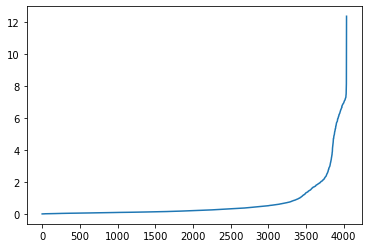

In [10]:
K = katz_by_graph_exploration(G5,D5,L5,0.85*v5,80,N_G)
print(np.mean(K))
print(np.var(K))
K = list(K)
K.sort()
P = [i for i in range(N_G)]
plt.plot(P,K)
plt.show()

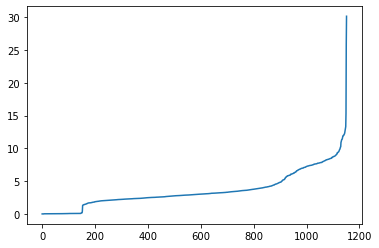

In [27]:
K = katz_by_graph_exploration(G2,D2,L2,0.85*v2,80,N_2)
K = list(K)
K.sort()
P = [i for i in range(N_2)]
plt.plot(P,K)
plt.show()

1.7727265814458797
26.089734066824832


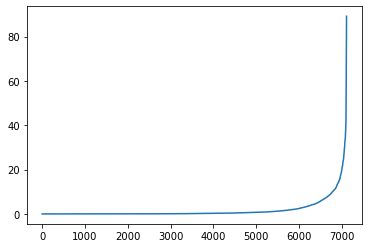

In [11]:
K = katz_by_graph_exploration(G3,D3,L3,0.85*v3,80,N_3)
print(np.mean(K))
print(np.var(K))
K = list(K)
K.sort()
P = [i for i in range(N_3)]
plt.plot(P,K)
plt.show()

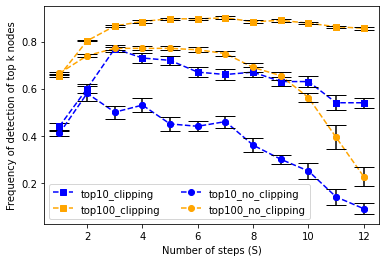

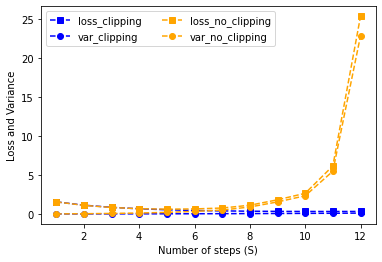

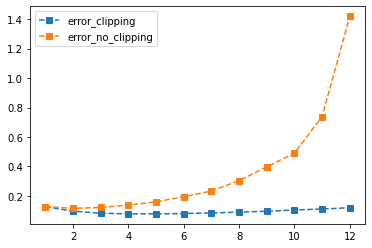

310.96980261802673


<Figure size 432x288 with 0 Axes>

In [10]:
t1 = time.time()
alpha = 0.85*v5
STEP = [i for i in range(1,13)]
f1,f2 = plot_clipping_step(G5,D5,L5,0.85*v5,1/v5,STEP,ite=10)
t2 = time.time()
print(t2-t1)

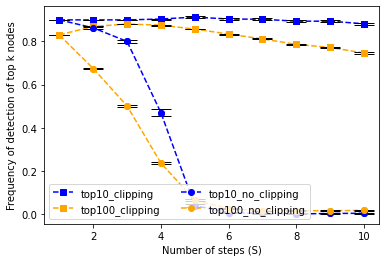

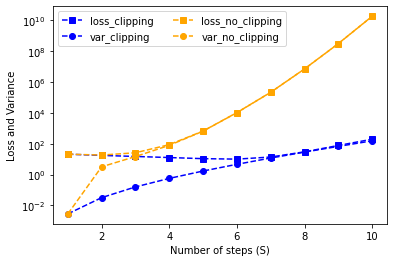

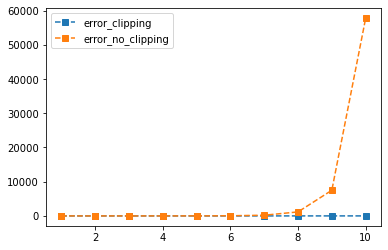

1580.9656386375427


<Figure size 432x288 with 0 Axes>

In [20]:
t1 = time.time()
alpha = 0.85*v3
STEP = [i for i in range(1,11)]
F1,F3 = plot_clipping_step(G3,D3,L3,0.85*v3,1.6/v3,STEP,ite=100)
t2 = time.time()
print(t2-t1)

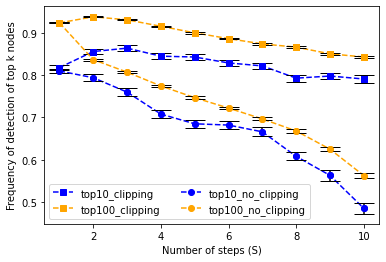

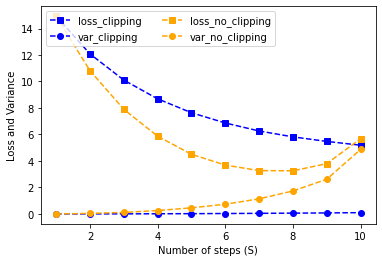

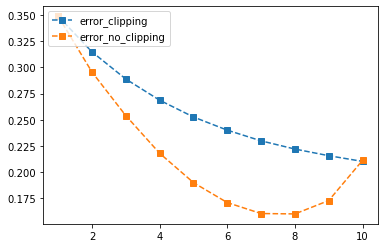

1057.9449517726898


<Figure size 432x288 with 0 Axes>

In [33]:
t1 = time.time()
alpha = 0.85*v2
STEP = [i for i in range(1,11)]
f1,f2 = plot_clipping_step(G2,D2,L2,0.85*v2,1/v2,STEP,ite=100)
t2 = time.time()
print(t2-t1)

In [21]:
print(F1)
print(F3)

[0.9000000000000006, 0.9000000000000006, 0.9000000000000006, 0.9040000000000006, 0.9130000000000006, 0.9040000000000006, 0.9030000000000006, 0.8940000000000006, 0.8940000000000006, 0.8820000000000006]
[0.8304999999999996, 0.8697000000000018, 0.8807000000000011, 0.8756000000000013, 0.8574000000000006, 0.8344000000000005, 0.8117000000000002, 0.7867000000000007, 0.7721000000000007, 0.7464000000000003]


In [34]:
print(f1)
print(f2)
print(0.85*v2)

[0.8180000000000006, 0.8560000000000005, 0.8640000000000005, 0.8450000000000006, 0.8430000000000006, 0.8290000000000006, 0.8220000000000006, 0.7930000000000006, 0.7980000000000006, 0.7910000000000006]
[0.9238999999999996, 0.9380999999999994, 0.9310999999999995, 0.9156999999999998, 0.9003000000000005, 0.8865000000000012, 0.874000000000001, 0.866400000000001, 0.8506000000000006, 0.8431000000000007]
0.005867420035312854


In [75]:
katz_by_graph_exploration(G3,D3,L3,0.9*v3,80,N_3)[0:4]

array([ 1.92600872,  0.        , 62.28687311,  3.16445353])

8.740122755233495
0.09000000000000001


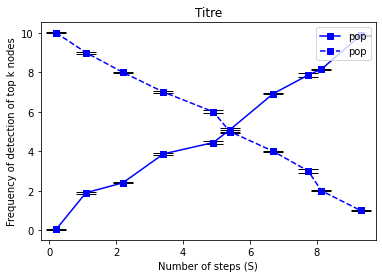

In [18]:
A = [i + np.random.random() for i in range(10)]
C = [i + np.random.random() for i in range(10)]
B = [0.1*np.random.random() for i in range(10)]
D = [10-i for i in range(10)]
print(np.var(A))
X = np.eye(10)
print(np.var(X[0,:]))
plt.errorbar(A,C,B,capsize=10, fmt='s', ecolor='black', markeredgecolor = "b", color='b')
plt.errorbar(A,D,B,capsize=10, fmt='s', ecolor='black', markeredgecolor = "b", color='b')
plt.plot(A,C,'-s',color='b',label='pop')
plt.plot(A,D,'-s',color='b',label='pop',linestyle='dashed')
plt.xlabel('Number of steps (S)')
plt.ylabel('Frequency of detection of top k nodes')
plt.legend(loc = "upper right")
plt.title("Titre")
plt.savefig("tt2.png",dpi=300)

In [72]:
A = count_path(G5,D5,L5,3,1,n)
#A2 = count_path(G5,D5,L5,10,1,n)
B = count_path_noise(G5,D5,L5,3,1,n,1)
C = count_path_clipping(G5,D5,L5,0.1/v5,3,1,n,1)

In [73]:
print(A[0:5])
print(B[0:5])
print(C[0:5])
#print(A2[0:5])
print(loss_bias_error(A,B,n))
print(loss_bias_error(A,C,n))

[804. 114.  25.  85.  25.]
[-12157.96054712 -15728.77953787  16407.81589072   1153.40490974
 -32198.52072539]
[263.6529715  237.90157532 103.97229954 263.6529715   33.48868259]
(307276346.404161, 1628.1388946779823, 4698.563414870247)
(45634.068210065256, -187.84123212167947, 73.34400951705916)


In [77]:
print(A[-1])

0.0


In [95]:
r_1 = katz_clipping_opt(G5,D5,L5,1/v5,0.85*v5,10,n,1)

In [88]:
r_k = katz_by_graph_exploration(G5,D5,L5,0.85*v5,50,n)

In [91]:
r_2 = katz_without_clipping(G5,D5,L5,0.85*v5,10,n,1)

In [97]:
R_1 = katz_clipping_opt(G5,D5,L5,1/v5,0.85*v5,1,n,1)
R_2 = katz_without_clipping(G5,D5,L5,0.85*v5,1,n,1)

In [98]:
print(r_k[0:5])
print(r_1[0:5])
print(r_2[0:5])
print(R_1[0:5])
print(R_2[0:5])
print(loss_bias_error(r_k,r_1,n))
print(loss_bias_error(r_k,r_2,n))
print(loss_bias_error(r_k,R_1,n))
print(loss_bias_error(r_k,R_2,n))

[2.07426271 0.11643072 0.0682589  0.12385893 0.06600527]
[2.53417976 0.12208406 0.20525825 0.60708249 0.28262079]
[ 2.29207493 -0.77757153 -4.47707929  2.79675952 -0.63642432]
[1.8070718  0.06914504 0.12610832 0.08086952 0.05940053]
[1.83045206 0.08801497 0.04055512 0.07707001 0.03936289]
(0.301981921054082, 0.11549680862838231, 0.10276910400161701)
(1.4208407124913305, 0.06360316765880926, 0.3465996381048877)
(1.546687822826463, 0.46997009957788405, 0.1277679540981966)
(1.5463910297294454, 0.4695554294493486, 0.12754381108169396)


In [116]:
Q = []
q = []
for i in range(10):
    Q.append(katz_clipping_opt(G5,D5,L5,1/v5,0.85*v5,1,n,1)[107])
    q.append(katz_clipping_opt(G5,D5,L5,1/v5,0.85*v5,1,n,1)[1912])

In [117]:
print(r_k[107])
print(Q)

9.393802269546262
[5.482071341170261, 5.473362156233189, 5.461681513871752, 5.465173095487541, 5.465802131510458, 5.476684494097235, 5.454280403935455, 5.445795442792401, 5.469047681909932, 5.475051709221614]


In [118]:
print(np.var(Q))
print((np.mean(Q)-r_k[107])**2)
S = 0
for i in range(10):
    S += (r_k[107]-Q[i])**2
print(S/10)

0.00010748046829949355
15.420600726996208
15.420708207464509


In [110]:
print(np.var(q))
print((np.mean(q)-r_k[2])**2)
S = 0
for i in range(10):
    S += (r_k[2]-q[i])**2
print(S/10)

0.0002462342479022898
0.0003008556664859364
0.000547089914388226


In [111]:
print(np.mean(r_k))

0.6985063004411818


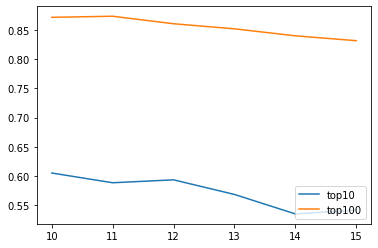

946.1759173870087


<Figure size 432x288 with 0 Axes>

In [28]:
t1 = time.time()
alpha = 0.85*v5
STEP = [i for i in range(10,16)]
STEP,F1,F2 = plot_clipping_step(G5,D5,L5,0.85*v5,1/v5,STEP,ite=60)
t2 = time.time()
print(t2-t1)

In [27]:
print(F1)
print(F2)

[0.4333333333333333, 0.6216666666666671, 0.7433333333333332, 0.7216666666666668, 0.7216666666666669, 0.7050000000000002, 0.6633333333333334, 0.6400000000000001, 0.6483333333333334]
[0.6598333333333338, 0.7981666666666668, 0.8700000000000006, 0.8941666666666677, 0.8985000000000005, 0.9030000000000005, 0.8996666666666671, 0.8896666666666675, 0.8841666666666671]


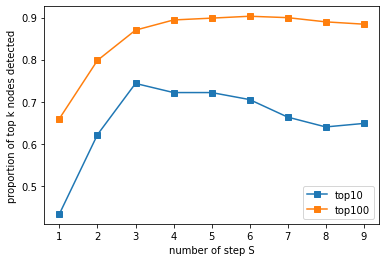

In [15]:
STEP = [i for i in range(1,10)]
plt.plot(STEP,F1,'-s',label = 'top10')
plt.plot(STEP,F2,'-s',label = 'top100')
plt.xlabel('number of step S')
plt.ylabel('proportion of top k nodes detected')
plt.legend(loc = 'lower right')
plt.show()

In [23]:
A1 = matrix_convertor(G1,D5)
v1,_,_ = eig_max_avg(G1,A1)
print(v1,v5)
alpha1 = 0.85*v1

0.006296519199751052 0.006158623641304036


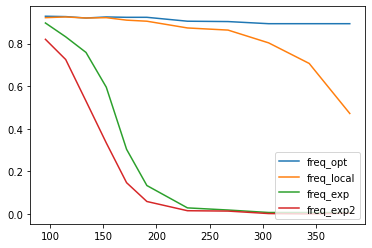

1212.9958670139313


<Figure size 432x288 with 0 Axes>

In [26]:
t1 = time.time()
alpha = 0.85*v1
X = [i/(10*alpha1) for i in range(5,10)]+[i/(10*alpha1) for i in range(10,21,2)]
plot_clipping_X(G1,D5,L5,0.85*v1,X,5,ite=60)
t2=time.time()
print(t2-t1)

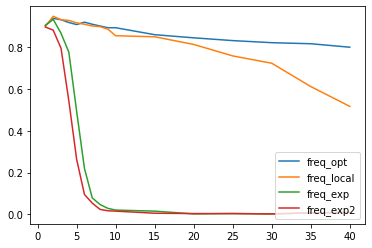

4923.35760140419


<Figure size 432x288 with 0 Axes>

In [36]:
t1 = time.time()
alpha = 0.85*v1
STEP = [i for i in range(1,10)] + [10+5*i for i in range(7)]
plot_clipping_step(G1,D5,L5,0.85*v1,1/v1,STEP,ite=60)
t2 = time.time()
print(t2-t1)

In [6]:
def deg_list(G):
    L = []
    for N in G.Nodes():
        L.append(N.GetDeg())
    L.sort()
    return L

def find_N(L,d):
    a = 0
    b = len(L)
    while True:
        N = (a+b)//2
        if L[N]<=d and L[N+1]>d:
            return len(L)-N+1
        elif L[N]>d:
            b = N-1
        else: a = N+1

            
def find_N_d(L,X):
    D = L[-1]
    d = 0
    N = 0
    score = np.inf
    while d<len(L):
        d+=1
        N = find_N(L,d)
        s = N*X + d*D
        if s > score:
            d = d-1
            N = find_N(L,d)
            return d,N,score
        score = s

def find_X(L):
    D = L[-1]
    for X in range(D):
        d,N,score = find_N_d(L,X)
        if score<=X*X:
            return D,X,N,d
        
def find_Nd(L):
        d,N,_ = find_N_d(L,1,1)
        return d,N

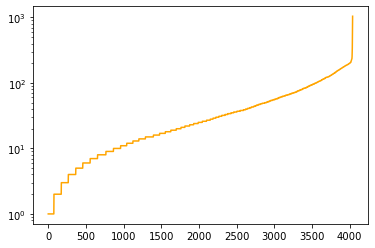

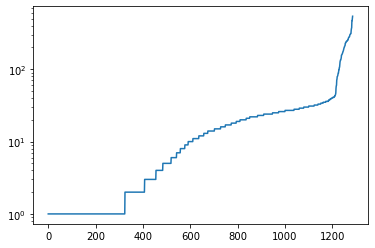

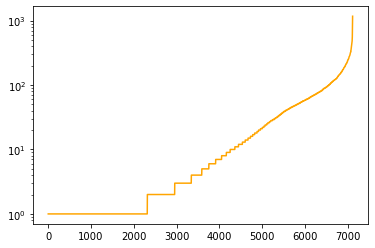

1 1167


In [9]:
G5 = snap.LoadEdgeList(snap.TUNGraph, "facebook_combined.txt", 0, 1)
#G1 = snap.GenRMat(4039, 88234, 0.6, 0.1, 0.15)
G1 = snap.LoadEdgeList(snap.TUNGraph, "lastfm4.txt", 0, 1)
N_G = G5.GetNodes()
n = N_G
v5 = 0.006158623641304036
alpha = 0.85*v5
Deg5 = np.array(deg_list(G5))
Deg1 = np.array(deg_list(G1))
X5 = [i for i in range(N_G)]
N_1 = len(Deg1)
X1 = [i for i in range(N_1)]
_, ax = plt.subplots()
ax.set_yscale('log')
plt.plot(X5,Deg5,color = 'orange')
plt.show()
_, ax = plt.subplots()
ax.set_yscale('log')
plt.plot(X1,Deg1)
plt.show()
L5,D5 = [i for i in range(N_G)],[i for i in range(N_G)]
L1,D1 = [i for i in range(N_1)],[i for i in range(N_1)]
G3 = snap.LoadEdgeList(snap.TNGraph, "Wiki-Vote.txt", 0, 1)
Deg3 = np.array(deg_list(G3))
N_3 = len(deg_list(G3))
X3 = [i for i in range(N_3)]
_, ax = plt.subplots()
ax.set_yscale('log')
plt.plot(X3,Deg3,color = 'orange')
plt.show()
L3,D3 = node_convertor(G3)
print(min(Deg3),max(Deg3))

In [11]:
np.mean(katz_by_graph_exploration(G5,D5,L5,alpha,40,N_G))

0.698094550033857

In [23]:
L1,D1 = node_convertor(G1)
A1 = matrix_convertor_un(G1,D1)
v1,_,_ = eig_max_avg(G1,A1)
np.mean(katz_by_graph_exploration(G1,D1,L1,0.85*v1,40,N_1))

2.181453030262639

In [22]:
print(v5)

0.006158623641304036


In [12]:
G2 = snap.TUNGraph.New()
for i in range(1000):
    G2.AddNode(i)
for i in range(1000):
    for j in range(i+1,1000):
        if i//500==j//500:
            if np.random.random()<0.5:
                G2.AddEdge(i,j)
        else:
            if np.random.random()<0.05:
                G2.AddEdge(i,j)
G2.PrintInfo("Python type TNGraph")

1152


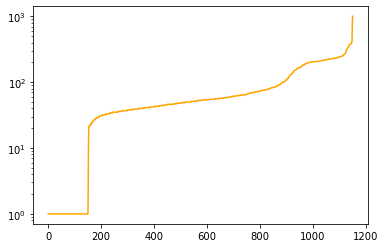

1 1002


In [11]:
G2 = snap.LoadEdgeList(snap.TUNGraph, "deezer_europe_edges_2.txt", 0, 1)
N_2 = len(deg_list(G2))
print(N_2)
Deg2 = np.array(deg_list(G2))
X2 = [i for i in range(N_2)]
_, ax = plt.subplots()
ax.set_yscale('log')
plt.plot(X2,Deg2,color = 'orange')
plt.show()
L2,D2 = node_convertor(G2)
print(min(Deg2),max(Deg2))

In [20]:
S=0
for N in G2.Nodes():
    S+=N.GetDeg()
print(S)

94581


In [30]:
print(len(L2))

1152


In [25]:
A2 = matrix_convertor_un(G2,D2)
v2,m2,a2 = eig_max_avg(G2,A2)
print(v2,m2,a2)

0.006902847100368064 0.000998003992015968 0.012173729261333616


In [26]:
P=0
for i in range(1152):
    for j in range(1152):
        if A2[i,j]>0.5:
            P+=1
print(P)

94581


In [23]:
47315*2

94630

In [8]:
G3 = snap.LoadEdgeList(snap.TNGraph, "Wiki-Vote.txt", 0, 1)
for i in range(4000):
    G3.AddNode(i)
for i in range(4000):
    for j in range(i+1,4000):
        if i//2000==j//2000:
            if np.random.random()<0.5:
                G3.AddEdge(i,j)
        else:
            if np.random.random()<0.05:
                G3.AddEdge(i,j)
G3.PrintInfo("Python type TNGraph")

RuntimeError: Execution stopped: !IsNode(NId) [Reason:'NodeId 3 already exists'], file C:\cygwin64\home\rok\build\snap\snap-core\graph.cpp, line 240

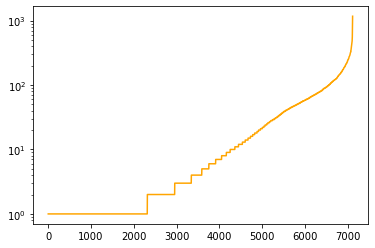

1 1167


In [8]:
G3 = snap.LoadEdgeList(snap.TNGraph, "Wiki-Vote.txt", 0, 1)
Deg3 = np.array(deg_list(G3))
N_3 = len(deg_list(G3))
X3 = [i for i in range(N_3)]
_, ax = plt.subplots()
ax.set_yscale('log')
plt.plot(X3,Deg3,color = 'orange')
plt.show()
L3,D3 = node_convertor(G3)
print(min(Deg3),max(Deg3))

In [9]:
A3 = matrix_convertor(G3,D3)
v3,m3,a3 = eig_max_avg(G3,A3)
print(v3,m3,a3)

0.022150996701210627 0.000856898029134533 0.03430932885841314


In [7]:
deg  = deg_list(G5)
D,X,N,d  = find_X(deg)
print(D,X,N,d)

1045 605 414 110


In [16]:
print(1/v5,0.85/alpha,0.5/alpha)

162.37394233563825 162.37394233563825 95.51408372684602


In [17]:
R = [1,1,2]
P = build_density(R,3,2)
def test(P,n,k):
    pointer = 0
    used = 0
    answer = []
    while pointer<n:
        if used>=k:
            break
        x = np.random.rand()
        if x<P[pointer,used]:
            answer.append(pointer)
            used+=1
        pointer+=1
    return answer 

def freq(P,n,k,nb):
    f1 = 0
    f2 = 0
    for _ in range(nb):
        X = test(P,n,k)
        a,b =  X[0],X[1]
        if a==0 and b==2:
            f1+=1/nb
        elif a==0 and b==1:
            f2+=1/nb
    return f1,f2

def freq2(P,n,k,nb):
    f1 = 0
    f2 = 0
    for _ in range(nb):
        X = one_time(P,n,k)
        a,b = X[0],X[1]
        if a+b==2 and a*b==0:
            f1+=1/nb
        elif a+b==1 and a*b==0:
            f2+=1/nb
    return f1,f2

In [91]:
freq(P,3,2,100000)

(0.4001400000002594, 0.19881000000005805)

In [94]:
R2 = [.5,.5,1]
P2 = build_density(R2,3,2)
freq(P2,3,2,100000)

(0.39919000000025845, 0.2009500000000602)

In [80]:
def one_time(R,n,k):
    I = [i for i in range(n)]
    output = []
    P = np.zeros(n)
    r = sum(R)
    for i in range(n):
        P[i]=R[i]/r
    for _ in range(k):
        #print(max(P))
        r = np.random.choice(I,p=P)
        output.append(int(r))
        #print(P[int(r)])
        P[int(r)]=0
        P=P/sum(P)
    return output

In [85]:
one_time(R,4,2)

[1, 3]

In [93]:
freq2(R,3,2,100000)

(0.4180400000002773, 0.16832000000002756)

In [98]:
n = N_G
M7 = exponential2(G5,D5,L5,0.5/alpha,alpha,1,10,n)
M4 = exponential(G5,D5,L5,0.5/alpha,alpha,2,10,n)
print(M4)
print(M7)

[1912, 1941, 1985, 2142, 2233, 2266, 2347, 2543, 2607, 3437]
[107, 1684, 1912, 3437, 0, 2347, 2543, 1888, 1800, 2266]


<ipython-input-97-124d4f340755>:240: RuntimeWarning: overflow encountered in double_scalars
  A[i,j]=A[i+1,j]+R[i]*A[i+1,j+1]
<ipython-input-97-124d4f340755>:245: RuntimeWarning: invalid value encountered in double_scalars
  P[i,j]=R[i]*A[i+1,j+1]/A[i,j]
<ipython-input-97-124d4f340755>:245: RuntimeWarning: overflow encountered in double_scalars
  P[i,j]=R[i]*A[i+1,j+1]/A[i,j]


In [15]:
r_6 = biggest_degree(G5,L5,n)
R_6 = [(r_6[i],i) for i in range(len(r_6))]
R_6 = sorted(R_6,key=lambda l : l[0],reverse = True)
M6 = [R_6[i][1] for i in range(10)]
print(M6)

[107, 1684, 1912, 3437, 0, 2543, 2347, 1888, 1800, 1663]


In [42]:
S1 = 0
S2 = 0
count = 0

In [55]:
#maxDeg,X,N,d = find_X(Deg_O1)
#print(X)
n  = len(list(G5.Nodes()))
alpha = 0.85*v5
#print(alpha)
X = 0.5/alpha
#r_2 = katz_by_clipping_noise(G5,D5,L5, 0.85/alpha, alpha, 5, n,1)
#r_3 = katz_clipping_opt(G5,D5,L5, 0.85/alpha, alpha, 5, n,1)
#r_1 = katz_by_graph_exploration(G5,D5,L5, alpha, 40,n)
r_2 = katz_clipping_opt(G5,D5,L5, 605, alpha, 10,n,1)
r_3 = katz_without_clipping(G5,D5,L5, alpha, 10,n,1)
#M4 = exponential(G5,D5,L5,0.5/alpha,alpha,5,10,n)
#M5 = expo2(G5,D5,L5,0.5/alpha,alpha,5,10,n)
#M7 = exponential2(G5,D5,L5,0.5/v5,alpha,5,10,n)
#r_6 = katz_without_clipping(G5,D5,L5, alpha, 1,n,1)
#r_7 = katz_without_clipping(G5,D5,L5, alpha, 5,n,1)

R_1 = [(r_1[i],i) for i in range(len(r_1))]
R_2 = [(r_2[i],i) for i in range(len(r_2))]
R_3 = [(r_3[i],i) for i in range(len(r_3))]
#R_6 = [(r_6[i],i) for i in range(len(r_6))]
#R_7 = [(r_7[i],i) for i in range(len(r_7))]
R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
R_3 = sorted(R_3,key=lambda l : l[0],reverse = True)
#R_6 = sorted(R_6,key=lambda l : l[0],reverse = True)
#R_7 = sorted(R_7,key=lambda l : l[0],reverse = True)
M1 = [R_1[i][1] for i in range(10)]
M2 = [R_2[i][1] for i in range(10)]
M3 = [R_3[i][1] for i in range(10)]
#M6 = [R_6[i] for i in range(3)]
#M7 = [R_7[i] for i in range(3)]

#print(M1)
#print(M6)
#print(M7)
#print(M2)
#print(M3)
#print(M3)
#print(M4)
#print(M5)
#print(M7)
#print(M6)
for m in M1:
    if m in M2:
        S1+=0.1
    if m in M3:
        S2+=0.1
count+=1
print(S1/count)
print(S2/count)

0.34615384615384615
0.23076923076923087


In [78]:
S = 0
for i in range(10000):
    S += np.random.laplace(scale = 1)
print(S)

101.1611886003387


In [17]:
#maxDeg,X,N,d = find_X(Deg_O1)
#print(X)
n  = len(list(G5.Nodes()))
alpha = 0.85*v5
#print(alpha)
X = 0.5/alpha
#print(X)
noise = alpha/(1-alpha*X)+2*alpha**3*X**2/((1-alpha*X)**2)
print(noise)
#Y = max(np.sqrt(maxDeg*d),N)
#print(phi*Y*alpha)
#b_th = alpha**2*phi*Y*(maxDeg-X)/(1-alpha*phi*Y)
#print(b_th)
r_2 = katz_by_clipping_noise(G1,D5,L5, 0.85/alpha, alpha, 5, n,1)
r_3 = katz_clipping_opt(G1,D5,L5, 0.85/alpha, alpha, 5, n,1)
r_1 = katz_by_graph_exploration(G1,D5,L5, alpha, 40,n)
r_4 = biggest_degree(G1,L5,n)

R_1 = [(r_1[i],i) for i in range(len(r_1))]
R_2 = [(r_2[i],i) for i in range(len(r_2))]
R_3 = [(r_3[i],i) for i in range(len(r_3))]
R_4 = [(r_4[i],i) for i in range(len(r_4))]
R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
R_3 = sorted(R_3,key=lambda l : l[0],reverse = True)
R_4 = sorted(R_4,key=lambda l : l[0],reverse = True)
M1 = [R_1[i][1] for i in range(10)]
M2 = [R_2[i][1] for i in range(10)]
M3 = [R_3[i][1] for i in range(10)]
M4 = [R_4[i][1] for i in range(10)]

print(M1)
print(M2)
print(M3)
print(M4)
print(M5)

0.020939320380433724


KeyboardInterrupt: 

In [49]:
#maxDeg,X,N,d = find_X(Deg_O1)
#print(X)
n  = 1000
alpha = 0.85*v2
#print(alpha)
X = 1/v2
#print(X)
#noise = alpha/(1-alpha*X)+2*alpha**3*X**2/((1-alpha*X)**2)
#print(noise)
#Y = max(np.sqrt(maxDeg*d),N)
#print(phi*Y*alpha)
#b_th = alpha**2*phi*Y*(maxDeg-X)/(1-alpha*phi*Y)
#print(b_th)
#r_2 = katz_by_clipping_noise(G1,D5,L5, 0.85/alpha, alpha, 5, n,1)
#r_3 = katz_clipping_opt(G1,D5,L5, 0.85/alpha, alpha, 5, n,1)
r_1 = katz_by_graph_exploration(G2,D2,L2, alpha, 80,n)
r_4 = biggest_degree(G2,L2,n)

R_1 = [(r_1[i],i) for i in range(len(r_1))]
#R_2 = [(r_2[i],i) for i in range(len(r_2))]
#R_3 = [(r_3[i],i) for i in range(len(r_3))]
R_4 = [(r_4[i],i) for i in range(len(r_4))]
R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
#R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
#R_3 = sorted(R_3,key=lambda l : l[0],reverse = True)
R_4 = sorted(R_4,key=lambda l : l[0],reverse = True)
M1 = [R_1[i][1] for i in range(10)]
#M2 = [R_2[i][1] for i in range(10)]
#M3 = [R_3[i][1] for i in range(10)]
M4 = [R_4[i][1] for i in range(10)]

print(M1)
#print(M2)
#print(M3)
print(M4)
#print(M5)

[765, 952, 527, 899, 517, 863, 520, 681, 925, 682]
[952, 765, 10, 527, 255, 899, 681, 443, 591, 639]


# End

In [36]:
print([R_1[i][1] for i in range(10)])
print([R_4[i][1] for i in range(15)])

[1912, 107, 2347, 2543, 2266, 2233, 2206, 1985, 2142, 2218]
[107, 1684, 1912, 3437, 0, 2543, 2347, 1888, 1800, 1352, 1663, 2266, 348, 483, 1941]


In [40]:
print([R_1[i][1] for i in range(10)])
print([look_for(R_1[i][1],R_4) for i in range(10)])

[1912, 107, 2347, 2543, 2266, 2233, 2206, 1985, 2142, 2218]
[2, 0, 6, 5, 11, 17, 22, 15, 18, 26]


In [38]:
def look_for(x,R):
    for i in range(len(R)):
        if R[i][1]==x:
            return i
    return -1

In [51]:
def frequency(nb_tour,nb_step,x_alpha=0.85,choose_X=False):
    t1 = time.time()
    f1 = 0
    f2 = 0
    f3 = 0
    for i in range(nb_tour):
        L1 = extract_subgraph2(G5,1000)
        G_O1 = G5.GetSubGraph(L1)
        L_O1, D_O1 = node_convertor(G_O1)
        A_O1 = matrix_convertor(G_O1,D_O1)
        v_O1,_,_ = eig_max_avg(G_O1,A_O1)
        n = len(list(G_O1.Nodes()))
        alpha = 0.95*v_O1
        if choose_X:
            Deg_G = deg_list(G_O1)
            maxDeg,x,Number,d = find_X(Deg_G)
        else:
            x = x_alpha/alpha
            
        
        r_2 = katz_by_clipping_noise(G_O1,D_O1,L_O1, x, alpha, 40, n,1)
        r_3 = katz_clipping_local(G_O1,D_O1,L_O1, x, alpha, nb_step, n,1)
        r_1 = katz_by_graph_exploration(G_O1,D_O1,L_O1, alpha, 40,n)
        r_4 = biggest_degree(G_O1,L_O1,n)

        R_1 = [(r_1[i],i) for i in range(len(r_1))]
        R_2 = [(r_2[i],i) for i in range(len(r_2))]
        R_3 = [(r_3[i],i) for i in range(len(r_3))]
        R_4 = [(r_4[i],i) for i in range(len(r_4))]
        
        R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
        R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
        R_3 = sorted(R_3,key=lambda l : l[0],reverse = True)
        R_4 = sorted(R_4,key=lambda l : l[0],reverse = True)
        
        M1 = [R_1[i][1] for i in range(10)]
        M2 = [R_2[i][1] for i in range(10)]
        M3 = [R_3[i][1] for i in range(10)]
        M4 = [R_4[i][1] for i in range(10)]
        
        for m in M1:
            if m in M2:
                f1+=1
            if m in M3:
                f2+=1
            if m in M4:
                f3+=1
                
    f1 = f1/(10*nb_tour)
    f2 = f2/(10*nb_tour)
    f3 = f3/(10*nb_tour)
    
    t2 = time.time()
    #print(t2-t1)
    
    return f1,f2,f3

def frequency2(nb_tour,nb_step,x_alpha=0.85,choose_X=False):
    t1 = time.time()
    f1 = 0
    f2 = 0
    f3 = 0
    for i in range(nb_tour):
        G_O1 = snap.GenRMat(1000, 10000, 0.6, 0.1, 0.15)
        L_O1, D_O1 = node_convertor(G_O1)
        A_O1 = matrix_convertor(G_O1,D_O1)
        v_O1,_,_ = eig_max_avg(G_O1,A_O1)
        n = len(list(G_O1.Nodes()))
        alpha = 0.85*v_O1
        if choose_X:
            Deg_G = deg_list(G_O1)
            maxDeg,x,Number,d = find_X(Deg_G)
        else:
            x = x_alpha/alpha
        
        r_2 = katz_by_clipping_noise(G_O1,D_O1,L_O1, x, nb_step, 40, n,1)
        r_3 = katz_clipping_local(G_O1,D_O1,L_O1, x, alpha, nb_step, n,1)
        r_1 = katz_by_graph_exploration(G_O1,D_O1,L_O1, alpha, 40,n)
        r_4 = biggest_degree(G_O1,L_O1,n)

        R_1 = [(r_1[i],i) for i in range(len(r_1))]
        R_2 = [(r_2[i],i) for i in range(len(r_2))]
        R_3 = [(r_3[i],i) for i in range(len(r_3))]
        R_4 = [(r_4[i],i) for i in range(len(r_4))]
        
        R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
        R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
        R_3 = sorted(R_3,key=lambda l : l[0],reverse = True)
        R_4 = sorted(R_4,key=lambda l : l[0],reverse = True)
        
        M1 = [R_1[i][1] for i in range(10)]
        M2 = [R_2[i][1] for i in range(10)]
        M3 = [R_3[i][1] for i in range(10)]
        M4 = [R_4[i][1] for i in range(10)]
        
        for m in M1:
            if m in M2:
                f1+=1
            if m in M3:
                f2+=1
            if m in M4:
                f3+=1
                
    f1 = f1/(10*nb_tour)
    f2 = f2/(10*nb_tour)
    f3 = f3/(10*nb_tour)
    
    t2 = time.time()
    print(t2-t1)
    
    return f1,f2,f3
            
def freq(G,D,L,v,nb_step1,nb_step2,n_big = 10,x_alpha1=0.5,x_alpha2=0.85,choose_X=False):
    t1 = time.time()
    f1 = 0
    f2 = 0
    f3 = 0
    if True:
        n  = len(list(G.Nodes()))
        alpha = 0.85*v
        x1 = x_alpha1/alpha
        x2 = x_alpha2/alpha            
        
        r_2 = katz_by_clipping_noise(G,D,L, x1, alpha, nb_step1, n,1)
        r_3 = katz_clipping_local(G,D,L, x2, alpha, nb_step2, n,1)
        r_1 = katz_by_graph_exploration(G,D,L, alpha, 40,n)
        r_4 = biggest_degree(G,L,n)

        R_1 = [(r_1[i],i) for i in range(len(r_1))]
        R_2 = [(r_2[i],i) for i in range(len(r_2))]
        R_3 = [(r_3[i],i) for i in range(len(r_3))]
        R_4 = [(r_4[i],i) for i in range(len(r_4))]
        
        R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
        R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
        R_3 = sorted(R_3,key=lambda l : l[0],reverse = True)
        R_4 = sorted(R_4,key=lambda l : l[0],reverse = True)
        
        M1 = [R_1[i][1] for i in range(n_big)]
        M2 = [R_2[i][1] for i in range(n_big)]
        M3 = [R_3[i][1] for i in range(n_big)]
        M4 = [R_4[i][1] for i in range(n_big)]
        
        print(M1)
        print(M2)
        print(M3)
        print(M4)
        
        for m in M1:
            if m in M2:
                f1+=1
            if m in M3:
                f2+=1
            if m in M4:
                f3+=1
                
    f1 = f1/n_big
    f2 = f2/n_big
    f3 = f3/n_big
    
    t2 = time.time()
    #print(t2-t1)
    
    return f1,f2,f3

In [52]:
freq(G5,D5,L5,v5,40,3,10)

[1912, 107, 2347, 2543, 2266, 2233, 2206, 1985, 2142, 2218]
[107, 1912, 1684, 3437, 2543, 2347, 1985, 1888, 1800, 1941]
[107, 1912, 1684, 2347, 2543, 3437, 1985, 2233, 2266, 2142]
[107, 1684, 1912, 3437, 0, 2543, 2347, 1888, 1800, 1663]


(0.5, 0.8, 0.4)

In [46]:
def grid_search(nb_tour):
    print("begin")
    x1_opt = 0
    opt1 = 0
    x2_opt = 0
    n=0
    opt2 = 0
    for x_alpha in np.linspace(0.05,0.95,10):
        f1,f2,f3 = frequency(nb_tour,5,x_alpha=x_alpha)
        if f1>opt1:
            x1_opt = x_alpha
            opt1 = f1
        if f2>opt2:
            opt2 = f2
            x2_opt = x_alpha
        print(x_alpha,f1,f2,f3)
    print("end")
    print(x1_opt,opt1)
    print(x2_opt,n,opt2)
    
def grid_search2(nb_tour):
    print("begin")
    x1_opt = 0
    opt1 = 0
    x2_opt = 0
    n=0
    opt2 = 0
    for x_alpha in np.linspace(0.05,0.95,10):
        f1,f2,f3 = frequency2(nb_tour,5,x_alpha=x_alpha)
        if f1>opt1:
            x1_opt = x_alpha
            opt1 = f1
        if f2>opt2:
            opt2 = f2
            x2_opt = x_alpha
        print(x_alpha,f1,f2,f3)
    print("end")
    print(x1_opt,opt1)
    print(x2_opt,n,opt2)

In [35]:
frequency(10,2,x_alpha = 0.5)

(0.73, 0.75, 0.71)

In [34]:
#frequency2(10,5,x_alpha = 0.5)

In [89]:
def biggest(L,nb):
    a = [(L[i],i) for i in range(len(L))]
    b = sorted(a,key = lambda l : l[0],reverse = True)
    c = np.array([b[i][0] for i in range(nb)])
    return c
    
    
def plot_biggest_global(G, Alpha, count = 40, choose_X = False, extract=False,N=1000,eps=1,big = 50):
    bias_th = 1
    if choose_X:
        Deg_G = deg_list(G)
        maxDeg,x,Number,d = find_X(Deg_G)
        Y = max(Number,np.sqrt(maxDeg*d))
    if extract:
        n=2*N
        while n>1.2*N:
            L = extract_subgraph2(G,N)
            G1 = G.GetSubGraph(L)
            n = len(list(G1.Nodes()))
    else:
        G1=G
        n = len(list(G1.Nodes()))
    n = len(list(G1.Nodes()))

    E1 = [0]*len(Alpha)           
    B1 = [0]*len(Alpha)
    B2 = [0]*len(Alpha)
    B3 = [0]*len(Alpha)
    R1 = [0]*len(Alpha)
    R2 = [0]*len(Alpha)
    S = [0]*len(Alpha)
    avg = [0]*len(Alpha)
    max_k = [0]*len(Alpha)
    L,D = node_convertor(G1)
    #A = matrix_convertor(G1,D)
    #r_k = katz_matrix(A,alpha)
    for i in range(len(Alpha)):
        alpha = Alpha[i]
        if not(choose_X):
            x = 0.85/alpha
        r_k = katz_by_graph_exploration(G1,D,L,alpha,count,n)
        for r in range(n):
            r_k[r] = max(r_k[r],1e-5)
        r_k = biggest(r_k,big)
        n_k1 = katz_by_clipping_noise(G1,D,L,x,alpha,count,n,eps)
        n_k1 = biggest(n_k1,big)
        e1,b1,r1 = loss_bias_error(r_k,n_k1,big)
        
        if choose_X and alpha*phi*Y<1:
            bias_th = alpha**2*phi*Y*(maxDeg-X)/(1-alpha*phi*Y)
        E1[i] = np.sqrt(e1) 
        B1[i] = b1
        B2[i] = bias_th
        B3[i] = max(r_k-n_k1)
        R1[i] = r1
        R2[i] = max((r_k-n_k1)/r_k)
        avg[i] = np.mean(r_k)
        max_k[i] = max(r_k)
        S[i] = alpha/(1-alpha*x)
        

    if False:
        _, ax = plt.subplots()
        ax.set_yscale('log')
        plt.plot(Alpha,E1,label = 'loss')
        plt.legend(loc = 'upper right')
        plt.show()

        plt.clf()
    
    if True:
        
        _, ax = plt.subplots()
        ax.set_yscale('log')
        plt.plot(Alpha,R2,label = 'max_relative_err')
        plt.plot(Alpha,R1,label = 'avg_relative_err')
        plt.legend(loc = 'lower right')
        plt.show()
        plt.clf()
    
    if True:
        _, ax = plt.subplots()
        ax.set_yscale('log')
        if choose_X:
            plt.plot(Alpha,B2,label = 'th')
        plt.plot(Alpha,E1,label = 'loss')
        plt.plot(Alpha,max_k,label = 'max_katz_value')
        #plt.plot(Alpha,avg,label=  'avg_katz_value')
        plt.plot(Alpha,B3,label = 'bias_max')
        plt.plot(Alpha,B1,label = 'bias_avg')
        plt.plot(Alpha,S,label = "sensitivity")
        plt.legend(loc = 'upper left')
        plt.show()
        plt.clf()
        
    if False:
        _, ax = plt.subplots()
        ax.set_yscale('log')
        H = [B3[i]/max_k[i] for i in range(len(Alpha))]
        plt.plot(Alpha,H)
        plt.show()
        plt.clf()

def plot_biggest_local(G, Alpha, count = 40, eps = 1,choose_X = False, extract=False,N=1000):
    bias_th = 1
    s = 1
    if choose_X:
        Deg_G = deg_list(G)
        maxDeg,x,Number,d = find_X(Deg_G)
        gamma = max(1/eps,Number)
        l = max(x,np.sqrt(maxDeg*d),np.sqrt(Number*d))
        R = max(x,Number,np.sqrt(d*maxDeg))
    if extract:
        n=2*N
        while n>1.2*N:
            L = extract_subgraph2(G,N)
            G1 = G.GetSubGraph(L)
            n = len(list(G1.Nodes()))
    else:
        G1=G
        n = len(list(G1.Nodes()))
    n = len(list(G1.Nodes()))

    E1 = [0]*len(Alpha)           
    B1 = [0]*len(Alpha)
    B2 = [0]*len(Alpha)
    B3 = [0]*len(Alpha)
    R1 = [0]*len(Alpha)
    R2 = [0]*len(Alpha)
    S = [0]*len(Alpha)
    avg = [0]*len(Alpha)
    max_k = [0]*len(Alpha)
    L,D = node_convertor(G1)
    #A = matrix_convertor(G1,D)
    #r_k = katz_matrix(A,alpha)
    for i in range(len(Alpha)):
        alpha = Alpha[i]
        if not(choose_X):
            x = 0.85/alpha
        r_k = katz_by_graph_exploration(G1,D,L,alpha,count,n)
        for r in range(n):
            r_k[r] = max(r_k[r],1e-5)
        r_k = biggest(r_k,big)
        n_k1 = katz_clipping_local(G1,D,L,x,alpha,40,n,eps)
        n_k1 = biggest(n_k1,big)
        e1,b1,r1 = loss_bias_error(r_k,n_k1,big)
        
        if choose_X and alpha*3*R<1:
            bias_th = alpha**2*gamma*maxDeg/(1-alpha*3*R)
        if choose_X and np.sqrt(5)*alpha*l<1:
            s = alpha*count/(1-np.sqrt(5)*alpha*l)
        E1[i] = e1 
        B1[i] = b1
        B2[i] = bias_th
        B3[i] = max(r_k-n_k1)
        R1[i] = r1
        R2[i] = max((r_k-n_k1)/r_k)
        avg[i] = np.mean(r_k)
        max_k[i] = max(r_k)
        S[i] = s


    if False:
        _, ax = plt.subplots()
        ax.set_yscale('log')
        plt.plot(Alpha,E1,label = 'loss')
        plt.legend(loc = 'upper right')
        plt.show()

        plt.clf()
    
    if True:
        
        _, ax = plt.subplots()
        ax.set_yscale('log')
        plt.plot(Alpha,R2,label = 'max_relative_err')
        plt.plot(Alpha,R1,label = 'avg_relative_err')
        plt.legend(loc = 'lower right')
        plt.show()
        plt.clf()
    
    if True:
        _, ax = plt.subplots()
        ax.set_yscale('log')
        if choose_X:
            plt.plot(Alpha,B2,label = 'th')
        plt.plot(Alpha,max_k,label = 'max_katz_value')
        #plt.plot(Alpha,avg,label=  'avg_katz_value')
        plt.plot(Alpha,B3,label = 'bias_max')
        #plt.plot(Alpha,B1,label = 'bias_avg')
        plt.plot(Alpha,S,label = "sensitivity")
        plt.legend(loc = 'lower right')
        plt.show()
        plt.clf()
        
    if False:
        _, ax = plt.subplots()
        ax.set_yscale('log')
        H = [B3[i]/max_k[i] for i in range(len(Alpha))]
        plt.plot(Alpha,H)
        plt.show()
        plt.clf()